<font color='red'>注：1-3节的处理和实验一模一样，其中打印输出内容删除了，留下了必要的数据处理过程</font><br>
<font color='red'>注：更改第四节的统计分析</font>

### 环境

In [1]:
#导包
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import sys
import math
import matplotlib as mpl
import seaborn as sns

mpl.rcParams['font.sans-serif'] = ['simsun']
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
#python 版本
print(sys.version)
#各种包版本
!pip list

3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]
Package                            Version
---------------------------------- -------------------
absl-py                            0.11.0
alabaster                          0.7.12
alembic                            1.5.7
anaconda-client                    1.7.2
anaconda-navigator                 1.9.12
anaconda-project                   0.8.3
argh                               0.26.2
asn1crypto                         1.3.0
astroid                            2.4.2
astropy                            4.0.1.post1
astunparse                         1.6.3
atomicwrites                       1.4.0
attrs                              19.3.0
autopep8                           1.5.3
Babel                              2.8.0
backcall                           0.2.0
backports.functools-lru-cache      1.6.1
backports.shutil-get-terminal-size 1.0.0
backports.tempfile                 1.0
backports.weakref                  1.0.post1
bc

### 读取数据

In [3]:
#_NASE_PATH存放数据的文件夹
_BASE_PATH = r'D:/DM/'
# _BASE_PATH = r'E:\python\data\成绩数据'

jupyter-core                       4.6.3
jupyter-highlight-selected-word    0.2.0
jupyter-latex-envs                 1.4.6
jupyter-nbextensions-configurator  0.4.1
jupyterlab                         2.1.5
jupyterlab-server                  1.2.0
Keras                              2.4.3
Keras-Preprocessing                1.1.2
keyring                            21.2.1
kiwisolver                         1.2.0
lazy-object-proxy                  1.4.3
libarchive-c                       2.9
lightgbm                           3.0.0
llvmlite                           0.33.0+1.g022ab0f
locket                             0.2.0
loguru                             0.5.3
lxml                               4.5.2
Mako                               1.1.4
Markdown                           3.3.3
MarkupSafe                         1.1.1
matplotlib                         3.2.2
mccabe                             0.6.1
menuinst                           1.4.16
mistune                            0.8.4
mkl-

In [4]:
#文件路径
files_path = [os.path.join(_BASE_PATH, path) for path in os.listdir(_BASE_PATH)]
#读取数据
data = [pd.read_excel(file_path) for file_path in files_path]
#合并数据
data = pd.concat(data,ignore_index=True)

### 数据清洗

#### 删除不相关列
序号列并无实际意义，直接删除

In [5]:
drop_columns = ['序号']
data.drop(drop_columns,axis=1, inplace=True)

#### 删除无用的行

<font face='宋体'>从上面可以看出学号中'<b>学号</b>'是错误的项，将其索引出来查看是什么</font>

<font face='宋体'>索引出来后，发现是重复的表头，可以直接删掉</font>

In [6]:
data.drop(index=data[data['学号']=='学号'].index,axis=0, inplace=True)
data[data['学号']=='学号']

Empty DataFrame
Columns: [学号, 开课学期, 班级名称, 课程号, 课程名称, 总成绩, 成绩标志, 课程性质, 课程属性, 学时, 学分, 开课单位, 录入人, 考试性质, 补重学期, 备注, 姓]
Index: []

#### 删除重复行

统计重复行

In [7]:
data.duplicated(keep=False).sum()

37512

删除重复行

In [8]:
data = data.drop_duplicates(subset=data.columns,ignore_index=True)


#### 处理缺失值
<hr style="border: .5px solid #ccc;">

1. <font face='宋体'>通过info查看每列的信息</font>
2. <font face='宋体'>通过isna函数统计缺失个数</font>
3. <font face='宋体'>查看具有缺失值的列，找出缺失值的可能原因</font>
4. <font face='宋体'>使用合理的方法填充缺失值</font>

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23062 entries, 0 to 23061
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   学号      23062 non-null  object
 1   开课学期    23062 non-null  object
 2   班级名称    23062 non-null  object
 3   课程号     23062 non-null  object
 4   课程名称    23062 non-null  object
 5   总成绩     23062 non-null  object
 6   成绩标志    144 non-null    object
 7   课程性质    21784 non-null  object
 8   课程属性    23062 non-null  object
 9   学时      23062 non-null  object
 10  学分      23062 non-null  object
 11  开课单位    23062 non-null  object
 12  录入人     23060 non-null  object
 13  考试性质    23062 non-null  object
 14  补重学期    976 non-null    object
 15  备注      2722 non-null   object
 16  姓       23062 non-null  object
dtypes: object(17)
memory usage: 3.0+ MB


#### 过滤数据
过滤出需要的数据，即：<b>考试性质只考虑“正常考试”（即只考虑初修成绩）和专业课</b>

##### 选择课程名称作为课程的标识
通过统计发现，虽然课程名称相同，但是课程号却是不同的，
我也不知道这里不同课程号课程会有什么区别，
这里为了方便起见，
假设课程名称相同，课程是一样的，<b>以课程名称为主，不使用课程号</b>

##### 对课程性质进行统一
又通过统计发现，相同课程名称，课程属性却不同的

即使 '班级名称','课程名称','开课学期','课程号' 都相同，仍然有许多课程的 '课程性质' 不同，这说明课程性质数据存在很大不一致现象

In [10]:
#通过groupby_col对data进行分租，统计每print_col是否为相同值，不同的进行输出，extra_col额外展示的列，is_display是否需要打印
def diff(data,groupby_col, print_col,extra_col=[],is_display=False):
    '''
    对数据进行分组，输出每组中 指定列 值不统一的分组及其相关信息

    Parameters
    ----------
    data : DataFranme
        需要统计的输入数据
    groupby_col: List
        数据data中的分组标志
    print_col : str
        统计的列，如果每组中该列的值不一样，则会输出该组
        该值必须属于data.columns
    extra_col : List, default []
        需要额外统计展示的列
    is_display : bool, default False
        是否打印出结果
        .. versionadded:: 0.0.0

    Returns
    -------
    dict
        返回字典，{分组标志值:每组中print_col中的值}
        只返回print_col为多个的值 
    '''
    diff_col = {}
    for c,df in data.groupby(groupby_col):
        #unique每组中print_col的去重值
        unique = df[print_col].unique()
        if unique.shape[0]>1:#过滤print_col值不一样个数少于2的
            diff_col[c] = unique.tolist()
            if is_display:
                print(c, '\t', unique, '\t',*[df[col].unique() for col in extra_col])
    return diff_col
# _ = diff(data,['班级名称','课程名称','开课学期','课程号'],'课程性质',[], True)


以课程名称为分组列，同一名称的课程按以下优先级顺序进行统一<br>
专业课 专业任选课 实践性环节 工程基础课 学科平台基础课程 学科基础课 公共基础课 公共课 公共任选课 通识教育基础课程 通识教育课程 其他<br>
特例：如果课程名称中含有 '校公选' 则直接认为是 公共任选课

In [11]:
#课程性质 不统一的 课程
diff_dict = diff(data,['课程名称'],'课程性质')

#applay回调函数 对课程性质进行统一
def call_func(x):
    global diff_dict
    # 优先级列表，越靠前，越优先选取
    priority = ['专业课', '专业任选课', '实践性环节', '工程基础课', '学科平台基础课程', '学科基础课', '通识教育基础课程', '通识教育课程' ,'公共基础课', '公共课', '公共任选课', '其他', np.nan]
    course_name = x['课程名称']
    #课程名称含有校公选 为特例
    if '校公选' in course_name:
        x['课程性质'] = '公共任选课'
    elif x['课程名称'] in diff_dict:
        name = np.nan
        for course_name in diff_dict[x['课程名称']]:
            if priority.index(course_name) < priority.index(name):
                name = course_name
        x['课程性质'] = name
    return x
data = data.apply(call_func,axis=1)
_ = diff(data,['课程名称'],'课程性质',[],True)

##### 过滤出初修成绩
通过统计发现， 当'<b>班级名称</b>','<b>课程名称</b>','<b>学号</b>'都相同时，但是会出现多条记录，这是由于刷分、重修、缓考或者补考等现象导致，所以需要进行逐一处理，得到初修成绩

In [12]:
#分组标志列
mark_col = ['班级名称','课程名称','课程号','学号','开课学期','课程性质']
# _ = diff(data,mark_col,'总成绩',['成绩标志','学时','学分','开课单位','录入人','考试性质','补重学期','备注'], True)

a. 如果 考试性质 不是 正常考试和补考一 则数据一定不是初修成绩，所以直接过滤重修

In [13]:
data['考试性质'].unique()

array(['重修一', '正常考试', '补考一'], dtype=object)

In [14]:
#选取正常考试和补考一的，补考也是初修成绩
data = data[(data['考试性质']=='正常考试') | (data['考试性质']=='补考一')]

去掉之后仍然有多条记录的的，

b. 计算机冲抵不属于初修，删掉

In [15]:
data = data[~(data['备注'].str.find('计算机冲抵')>-1)]

剩余重复都是，缓考，补考缺考的记录导致，缓考、补考算初修，选初次与补考最大值，补考时缺考算第一次的值，因为补考缺考是0，所以直接取最大值

补重学期时间比开课时间大的属于重修 删掉重修<br>
c. 例如开课学期为 2015-2016-1 补重学期 为 2015-2016-1则是补考，如果补重学期为2016-2017-1则为重修考试

In [16]:
#apply回调函数 对补重学期重新编码，0为空，1为补考，2为重修考试
def call_func(x):
    if type(x['补重学期'])== str:
        y1 = int(x['开课学期'].split('-')[0])
        y2 = int(x['补重学期'].split('-')[0])
        if(y1==y2):
            x['补重学期'] = 1
        else:
            x['补重学期'] = 2
    else:
        x['补重学期'] = 0
    return x
data = data.apply(call_func,axis=1)

In [17]:
#删掉重修的
data.drop(index=data[data['补重学期']==2].index,inplace=True)

剩余中出现多条记录是由于缺考、补考、缓考导致,他们都是初修的成绩<br>
d. 删除备注为缺考的行，缺考的分数是0，值是最小的

In [18]:
#删除备注含有缺考的
d_note = data[data.duplicated(mark_col,keep=False)]
_index = d_note[d_note['备注'].str.find('缺考')>-1].index
data.drop(index=_index,inplace=True)

In [19]:
_data = data.drop(columns='补重学期')
d_note = data[_data.duplicated(mark_col,keep=False)]
d_note = d_note.reset_index()
d_note = d_note.set_index(mark_col)
_index = d_note[(d_note['补重学期'] == 1)].index
dd = d_note.loc[_index]
index = dd[dd['补重学期']==0]['index']
index = index.reset_index(drop=True)
data.drop(index=index.values.tolist(),axis=1,inplace=True)

In [20]:
_data = data.drop(columns='补重学期')
d_note = data[_data.duplicated(mark_col,keep=False)]
data.drop(index=d_note[~((d_note['备注'].str.find('考')>-1) | (d_note['备注'].str.find('+')>-1))].index,inplace=True)

e. 剩下缓考，删除为总成绩0的

In [21]:
_d =diff(data,mark_col,'总成绩',['备注'], True)

('10404071', '关系数据库管理系统', '04040154a', '1040407128', '2011-2012-1', '其他') 	 ['0' '80'] 	 ['缓考' '缓考原80']


In [22]:
d_note = data[data.duplicated(mark_col,keep=False)]
data.drop(index=(d_note['总成绩']==0).index,inplace=True)

In [23]:
data.shape

(22034, 17)

##### 成绩转化
将部分'<b>总成绩</b>'的优、良、中、及格、不及格转化为分别对应95、85、75、65、45 计算机等级考试的 '优':95,'良':85,'不通过':45,'通过':70,'合格':70

In [24]:
# display(data['总成绩'].unique())

def switch(x):
    score = {'优':95,'良':85,'中':75,'及格':65,'不及格':45,'不通过':45,'通过':70,'合格':70}
    if x in score:
        return score[x]
    else:
        return x
data['总成绩'] = data['总成绩'].map(switch)
data['总成绩'] = data['总成绩'].astype(np.float)


<!-- <font face='宋体'>没有缺失值</font> -->
### 统计分析

#### 统计

思路：先对课程分组，得到每个课的数据，在对每个课数据对录入人分组，得到每个课每个老师的数据，最后计算

In [25]:
#寻找同一门课程，不同教师课程
course = {}
#最少10人课程
min_snum = 10
for course_name, course_data in data.groupby(by='课程名称'):
    t_group_data = course_data.groupby(by='录入人')
    #过滤课程只有一个老师教的课
    if len(t_group_data)<=1:
        continue
    #过滤四六级等等
    if '全国' in course_name:
        continue
    course[course_name] = []#每个课的数据是个列表
    for teacher, t_data in t_group_data:
        #过滤掉小于10的
        if(t_data.shape[0]<=min_snum):
            continue
        #每个课的每个老师的数据是个列表，分别是老师名、成绩的[平均值、标准差、方差]、学生成绩
        course[course_name].append([teacher, t_data['总成绩'].agg(['mean','std','var']).fillna(0), t_data['总成绩'].values.tolist()])
    if(len(course[course_name])<=1):
        #最终列表就1条数据，删掉
        del course[course_name]
course

数据的格式如下
```python
#数据，字典
{'Java程序设计':[['吕向阳',            #----第一个教师名称
                mean  82.422787    #-----成绩均值等Series
                std   11.429935
                var   130.643412
                Name: 总成绩, dtype: float64, 
                [92.2, 91.65, 80.0, 90.0, 94.0, 87.0, ... , 94.0, 87.0, 66.0, 69.0]], #---------- 成绩
                ['王志英',         #-------第二个教师
                mean  79.096970
                std   12.055496
                var   145.334991
                Name: 总成绩, dtype: float64, 
                [87.0, 82.0, 81.0, 83.0, 82.0, 69.0, ... , 75.0, 96.0, 88.0, 85.0]]]
...... #其他数据
}
 ```

#### 数据可视化

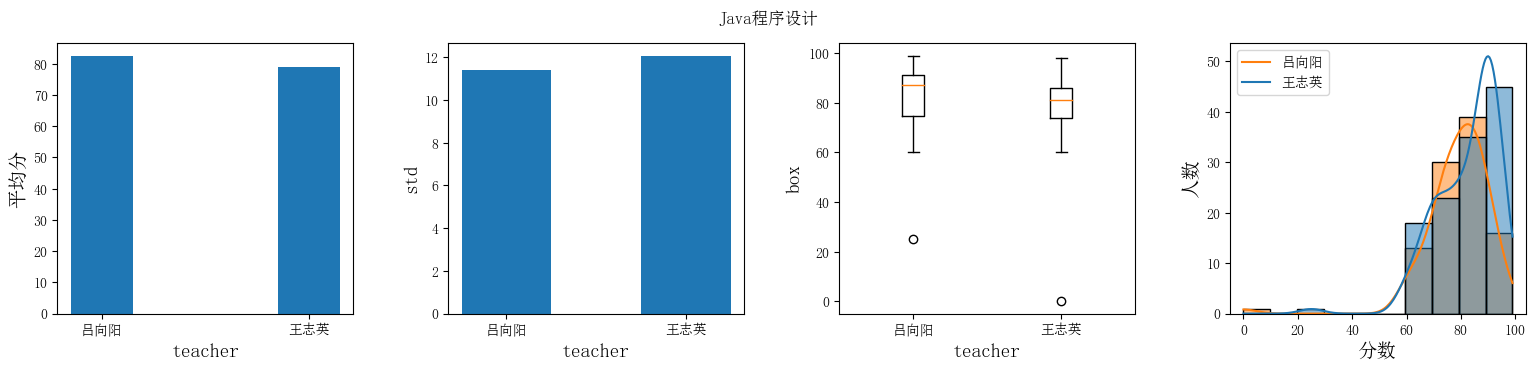

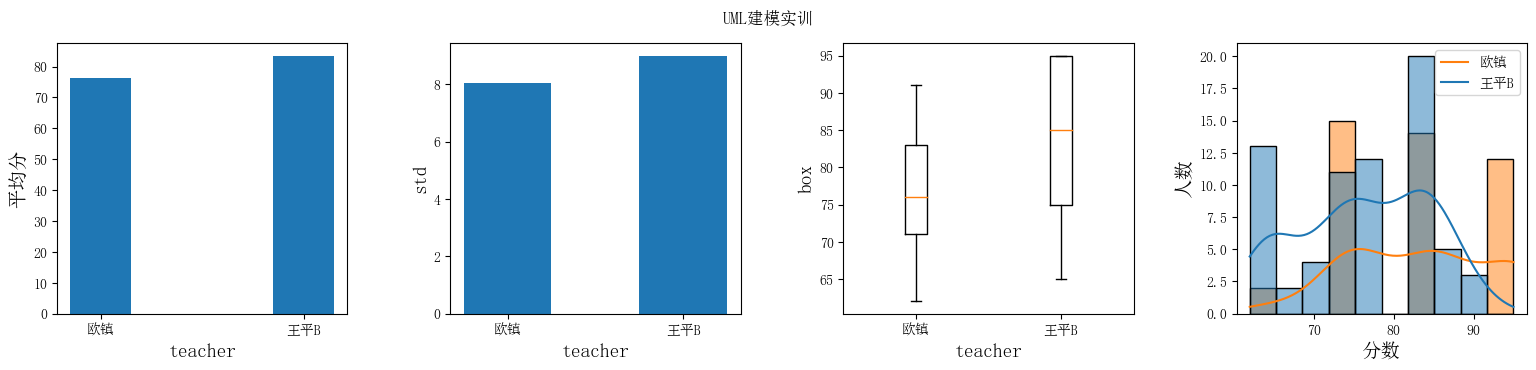

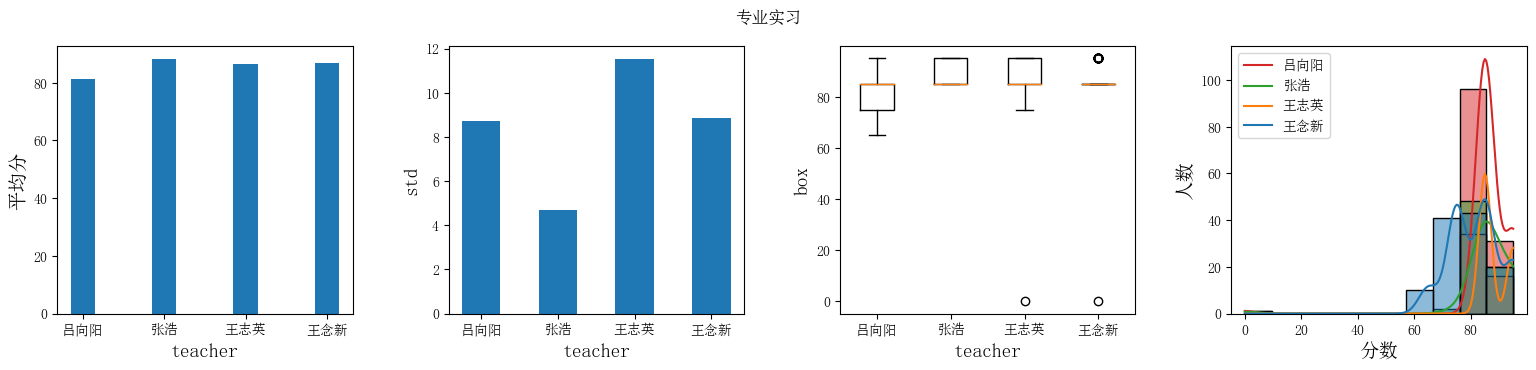

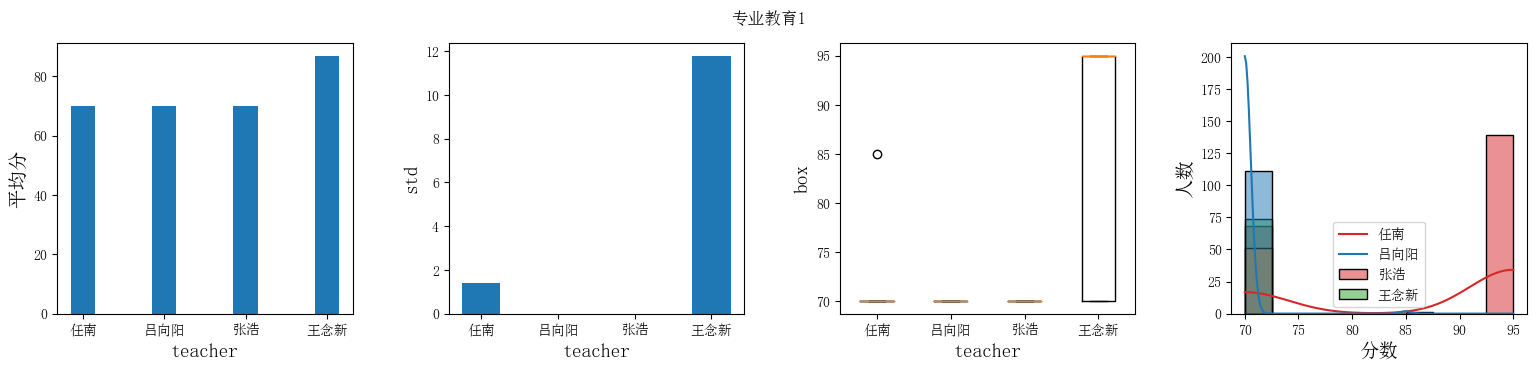

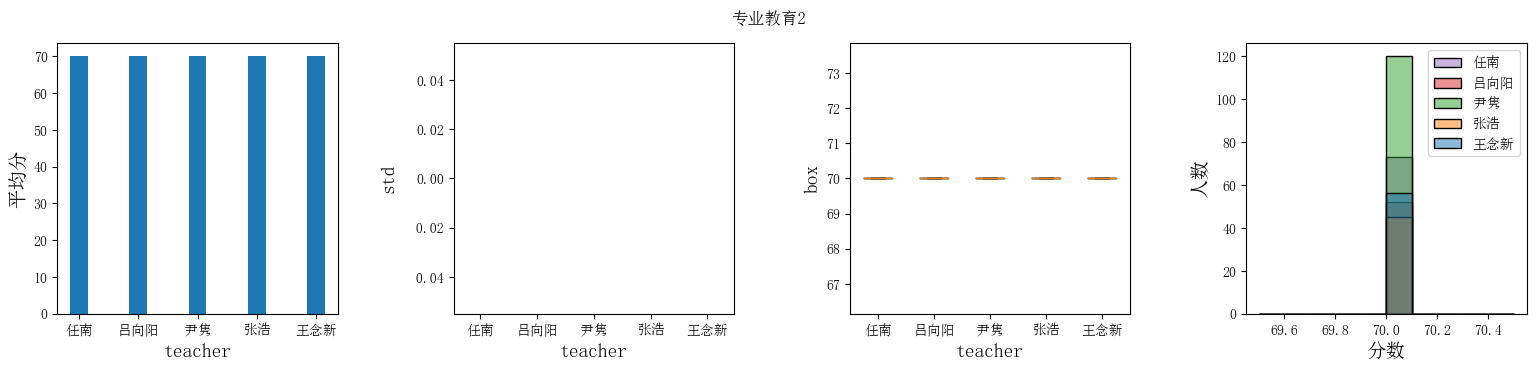

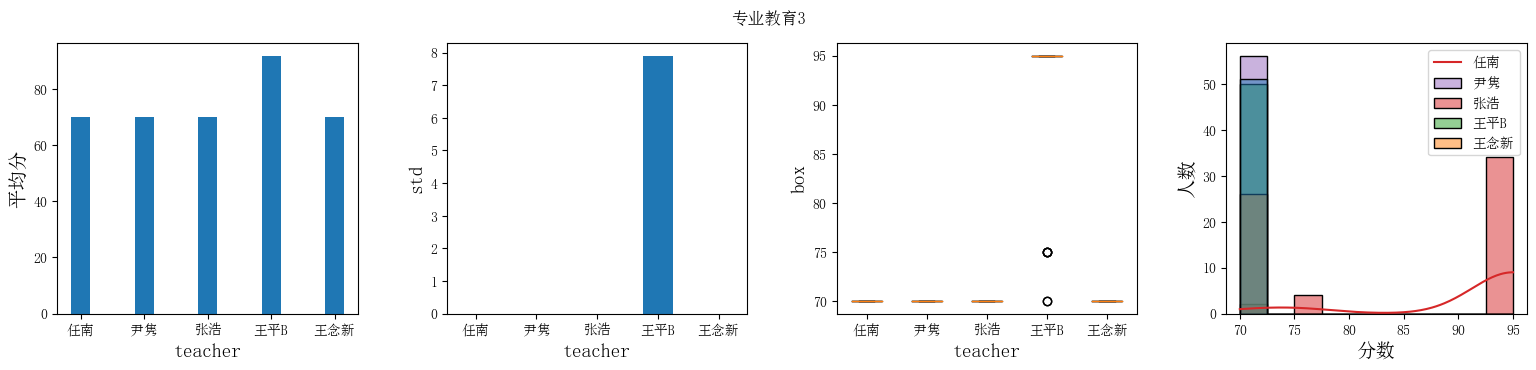

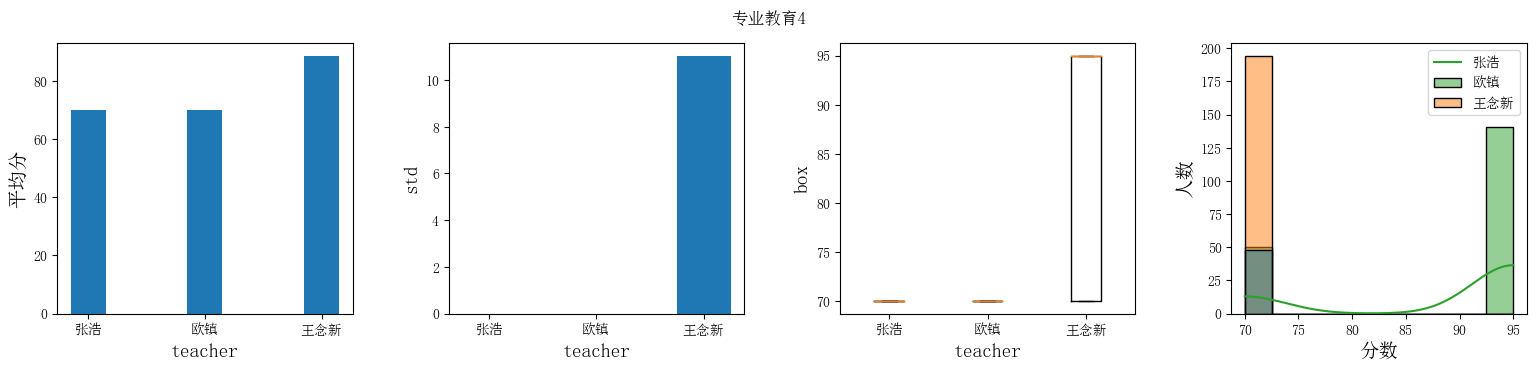

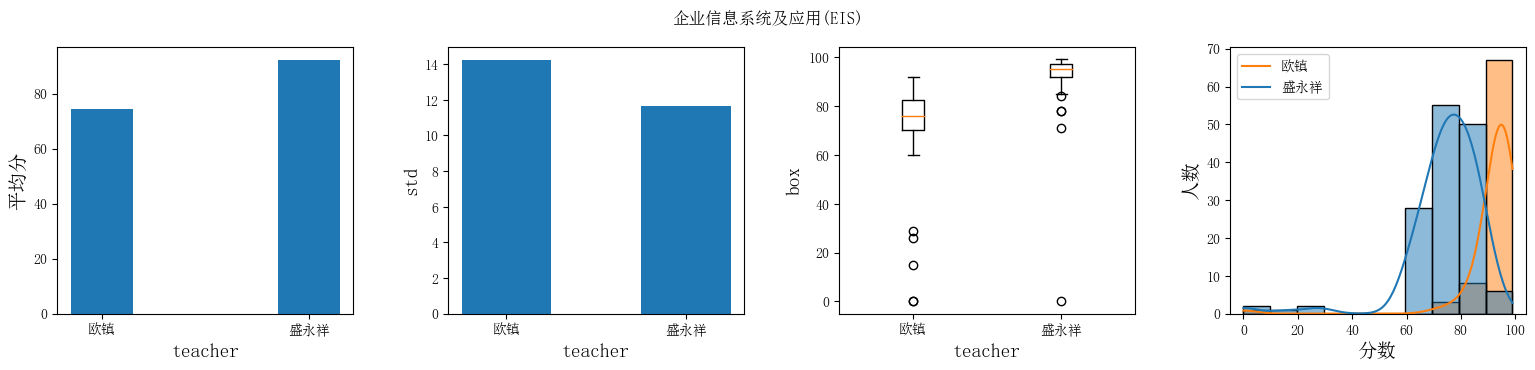

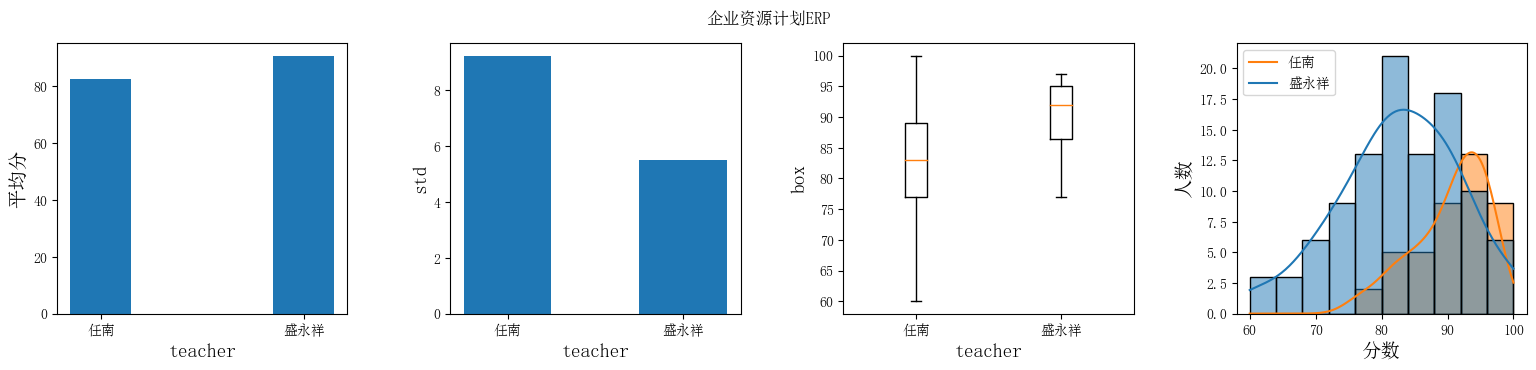

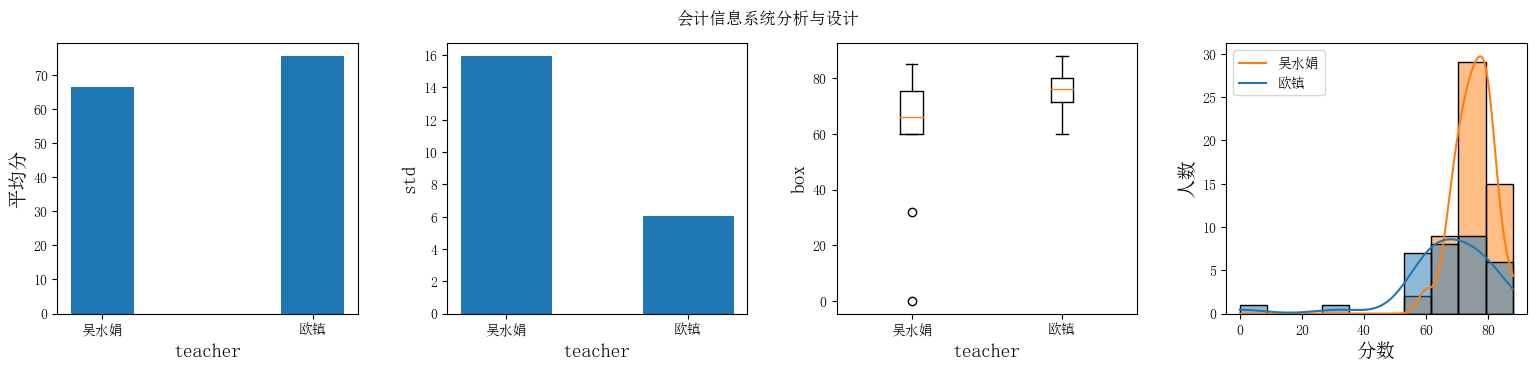

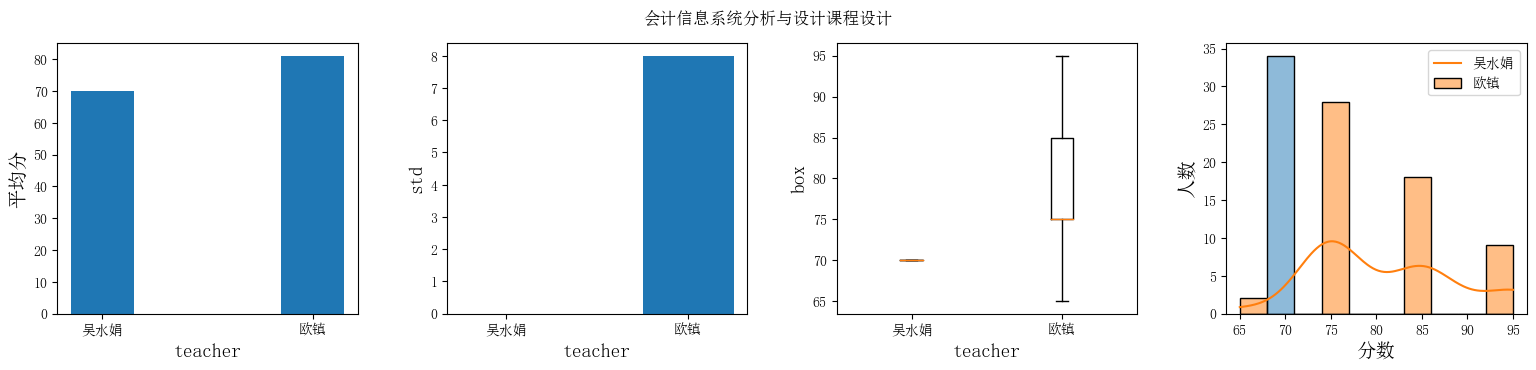

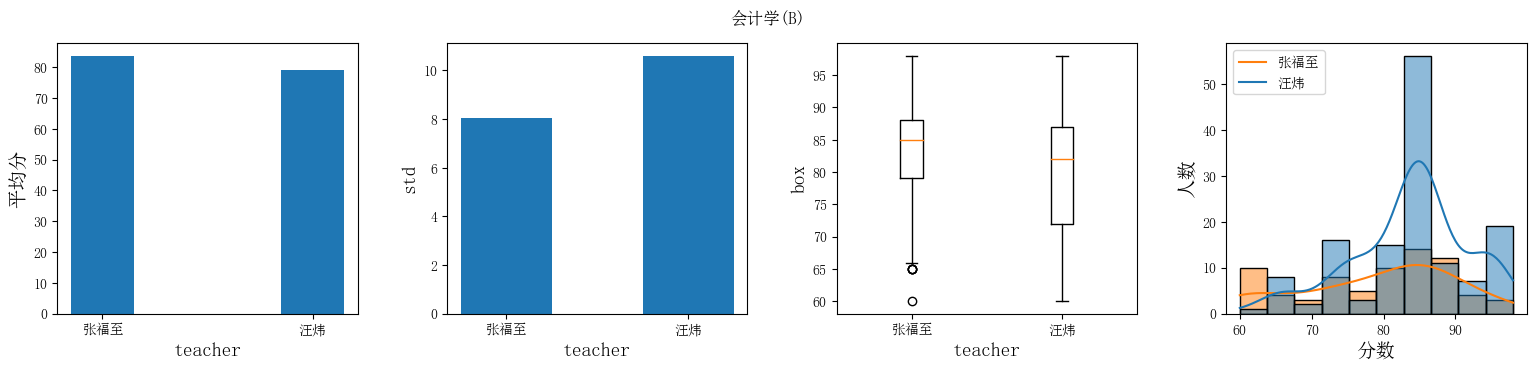

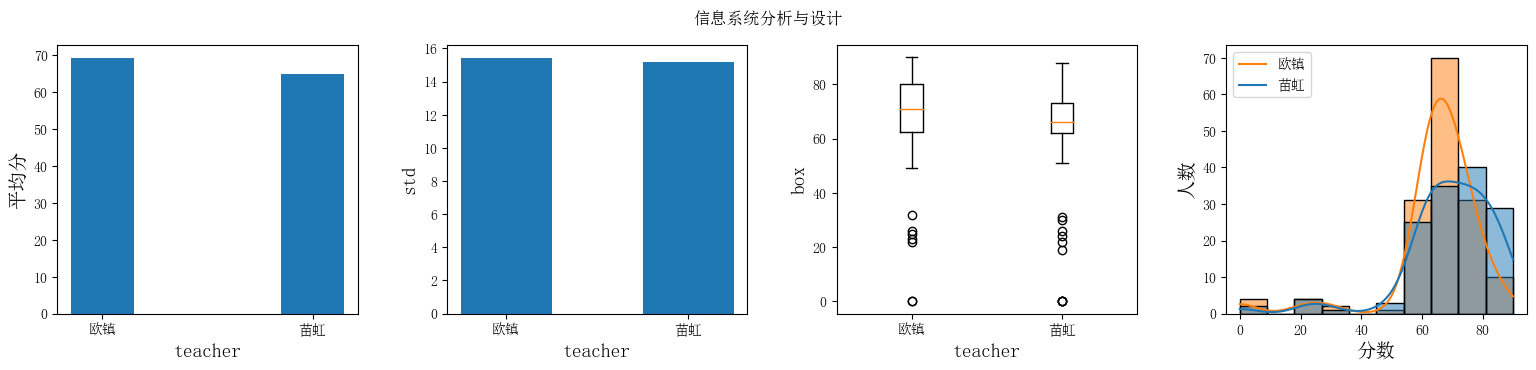

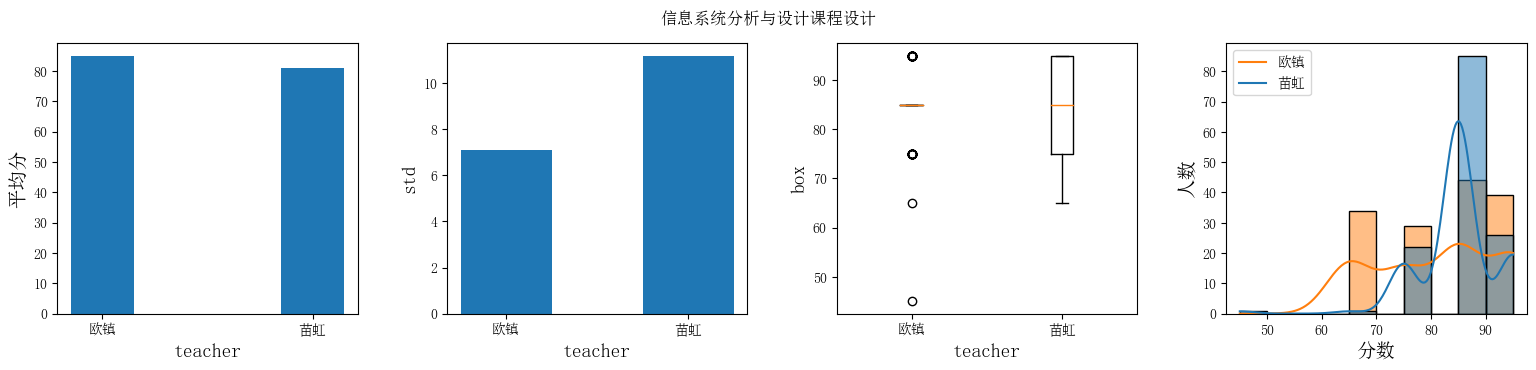

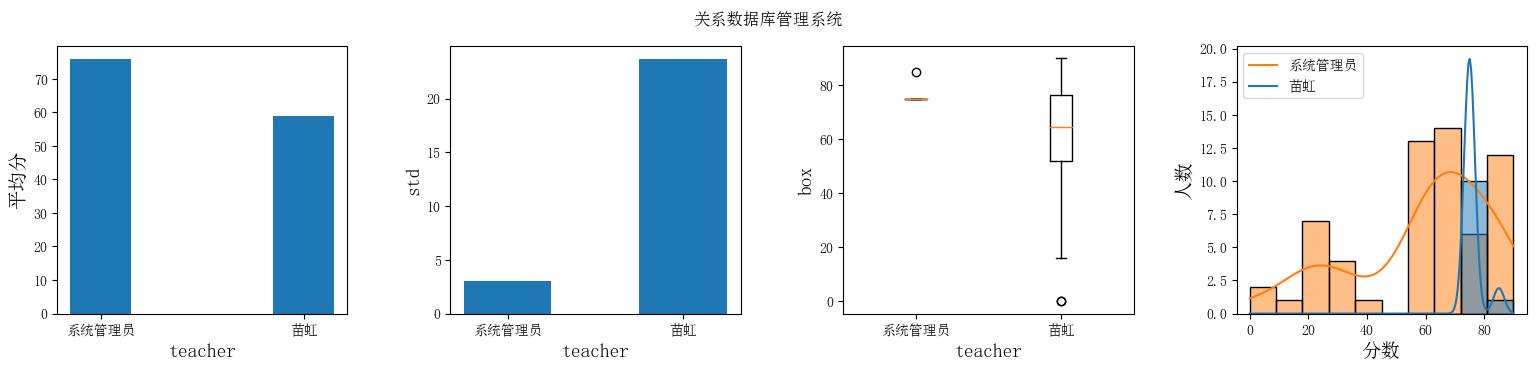

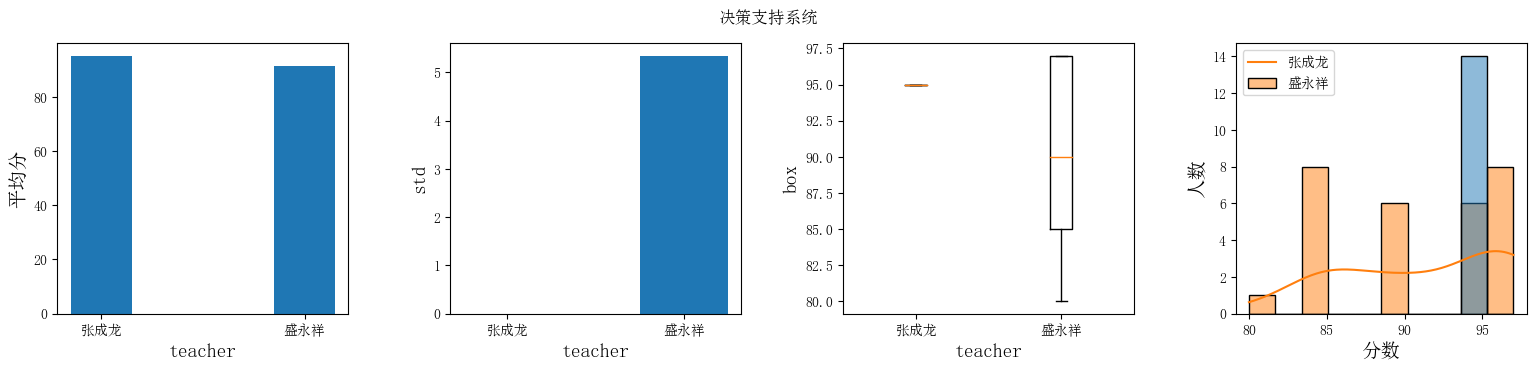

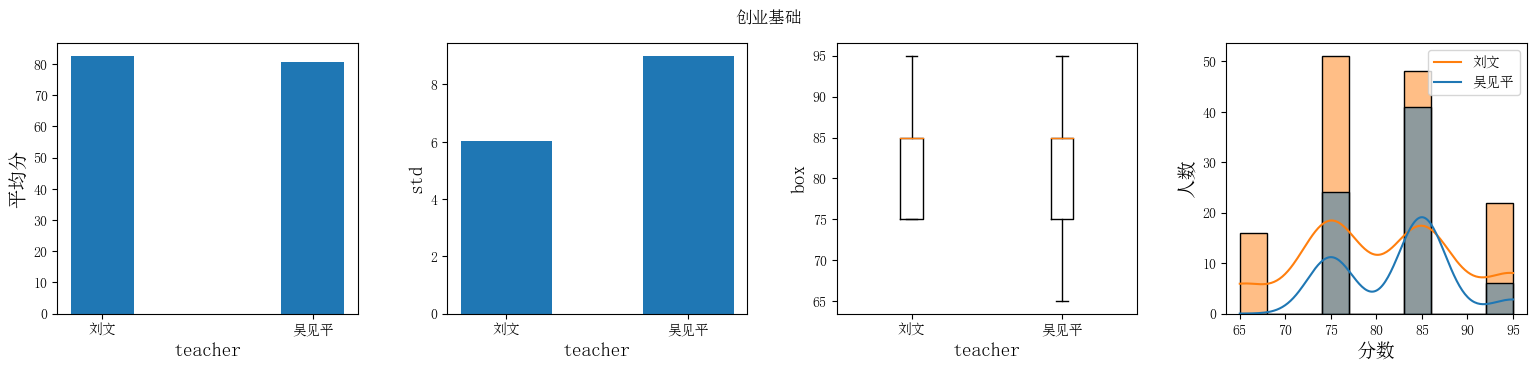

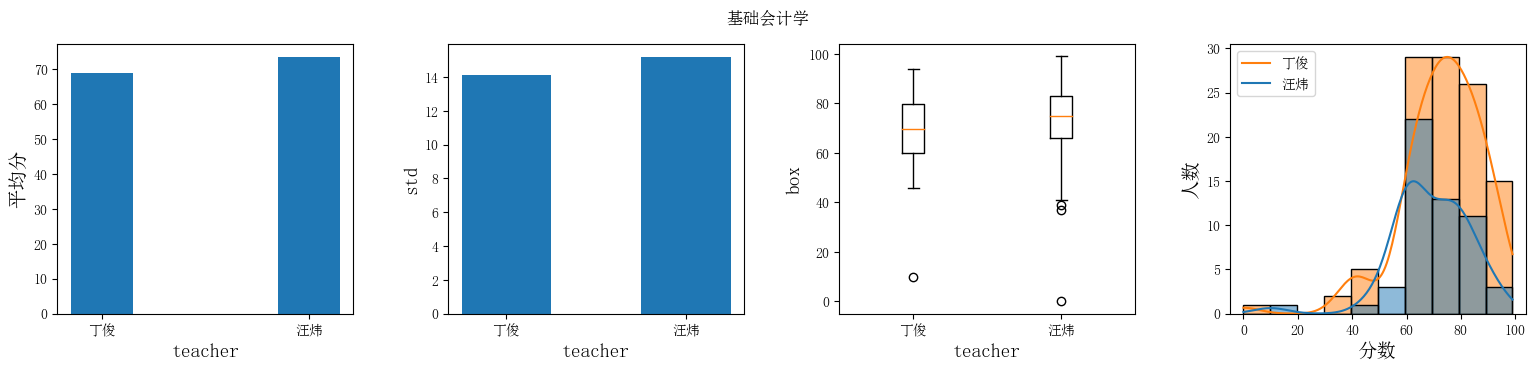

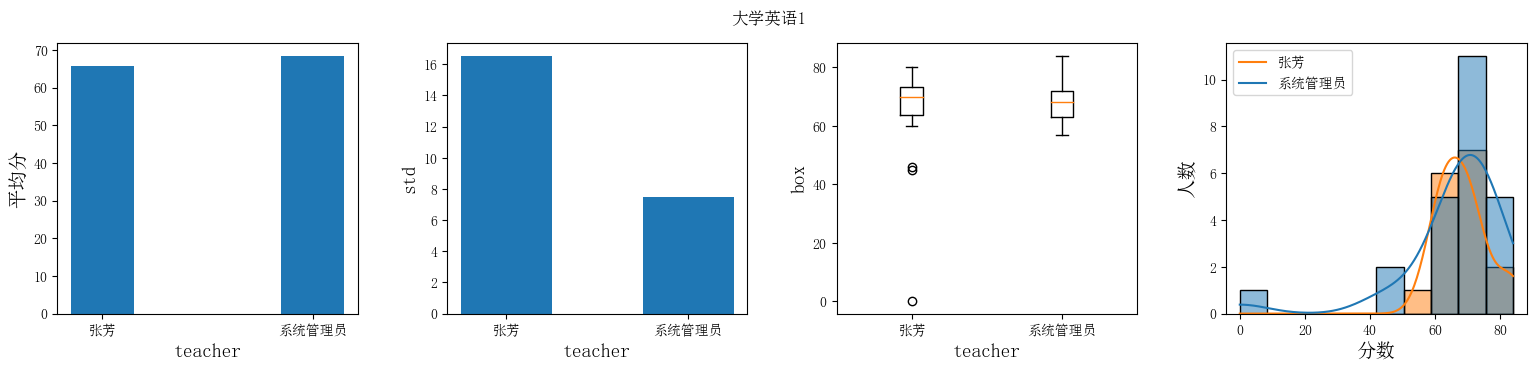

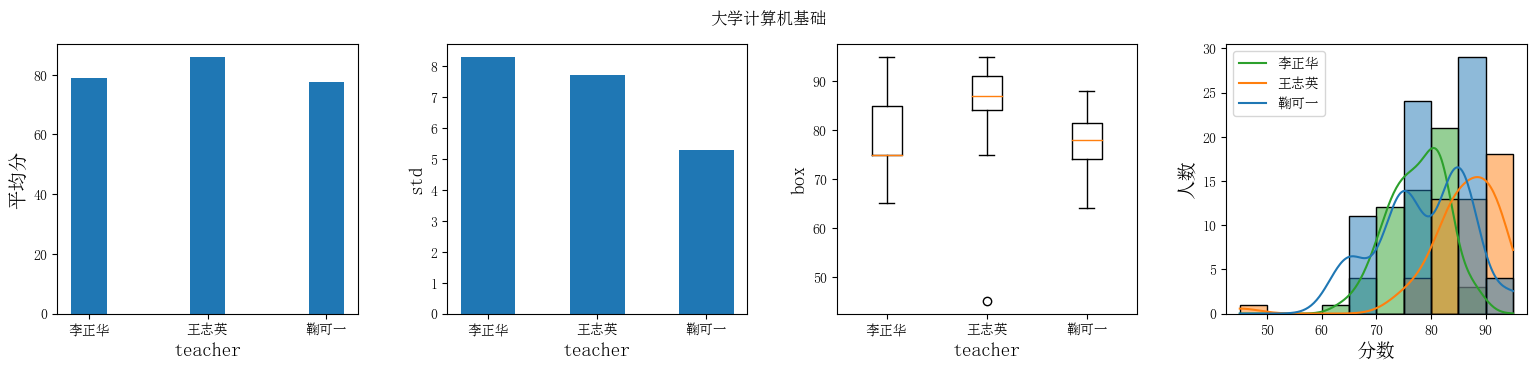

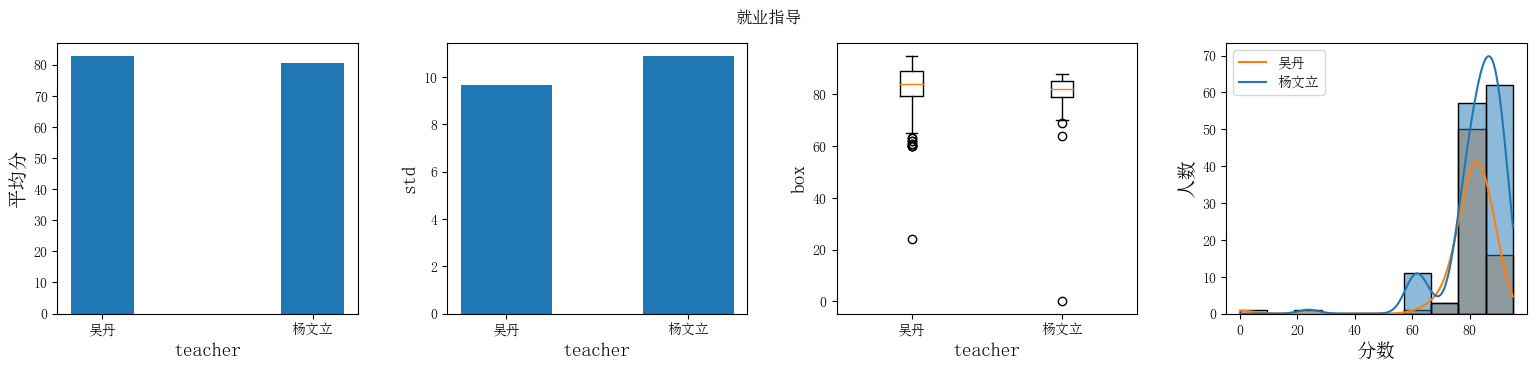

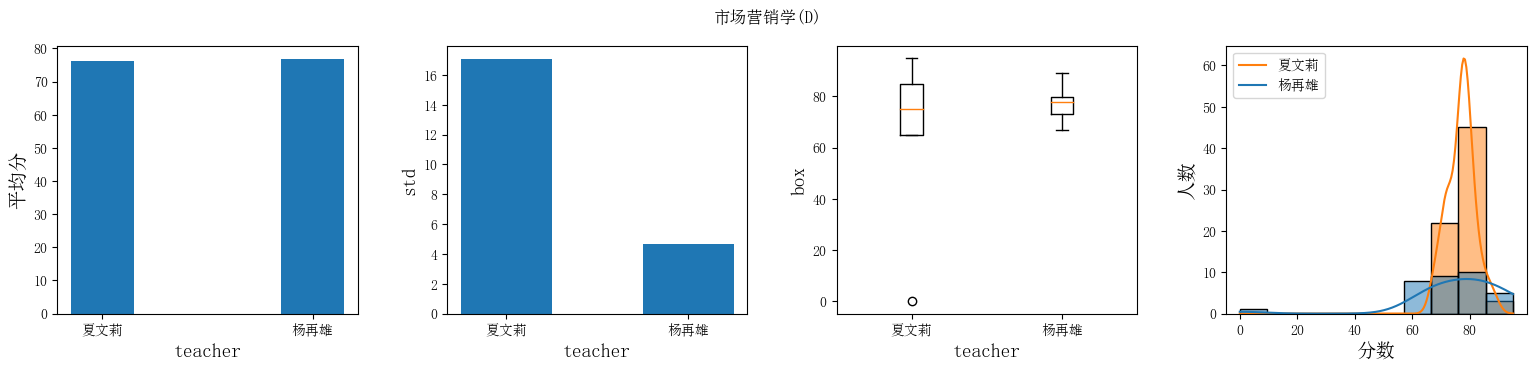

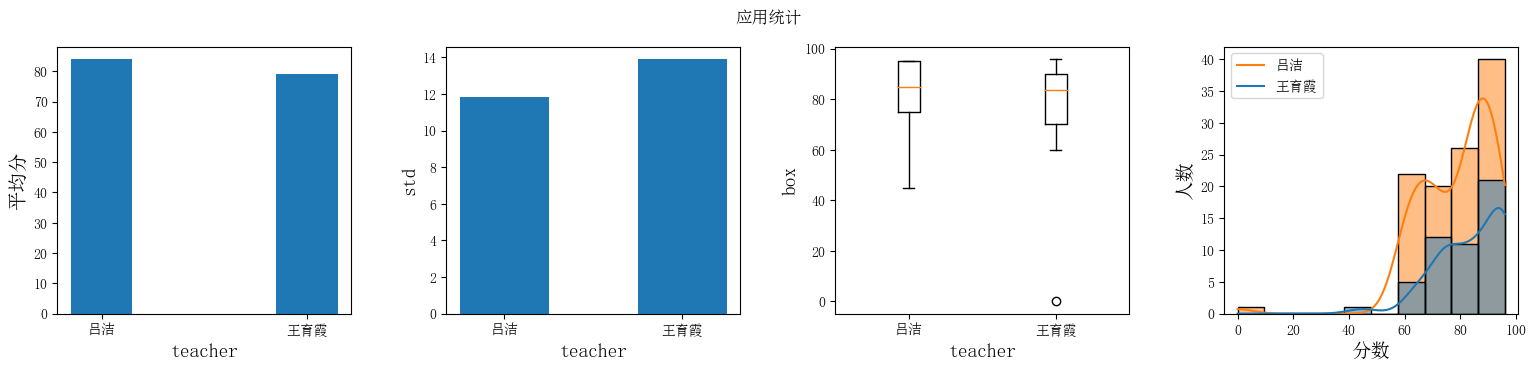

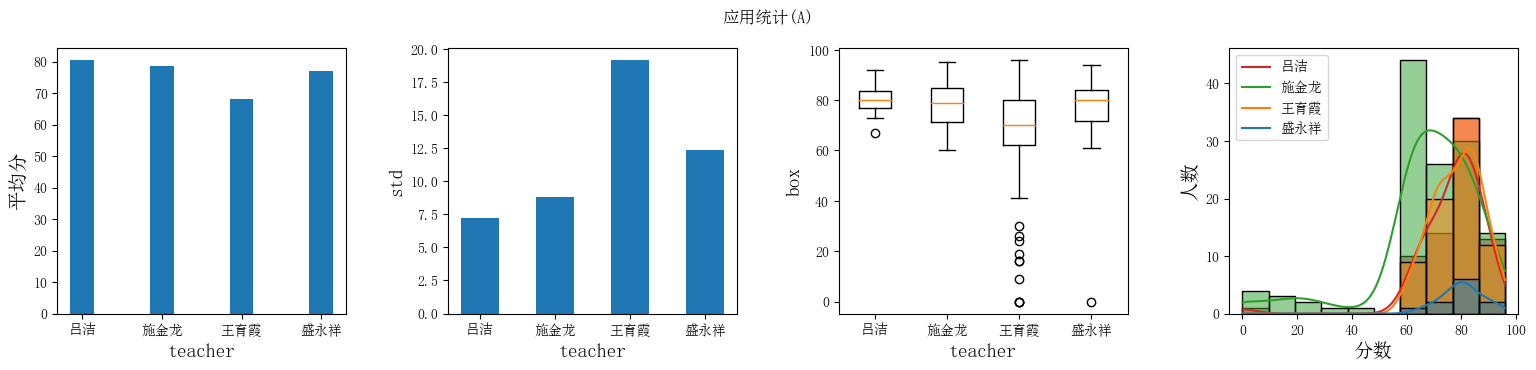

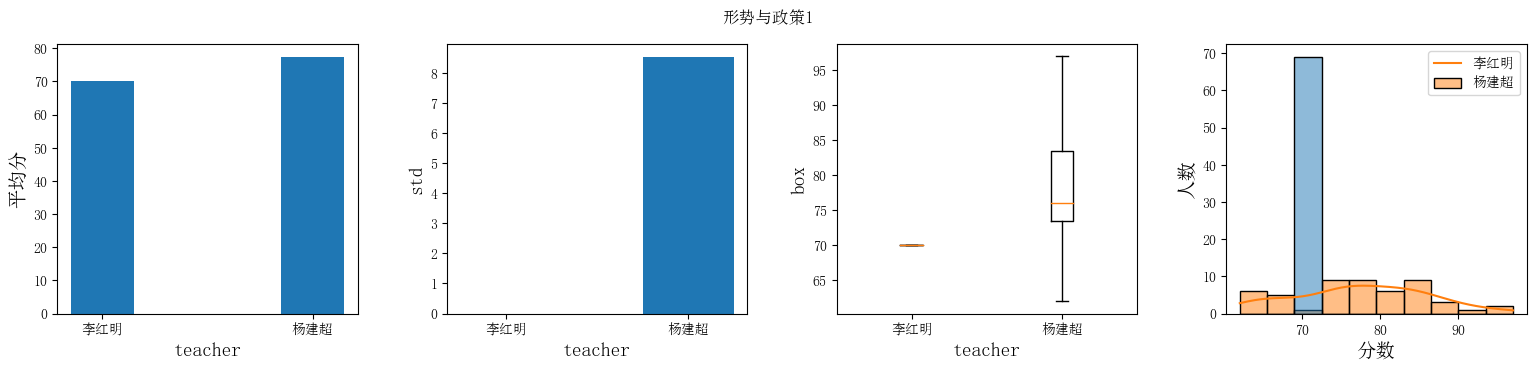

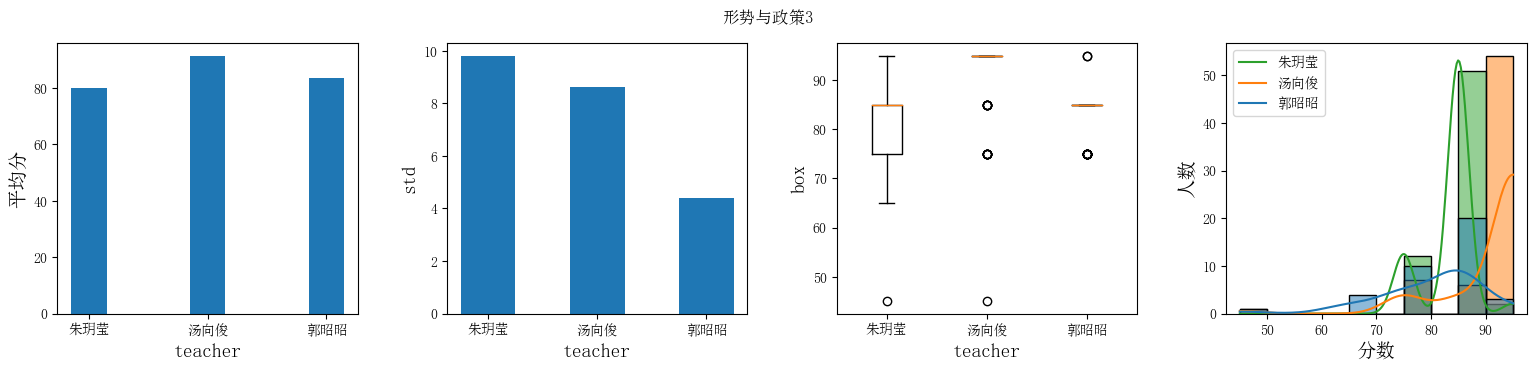

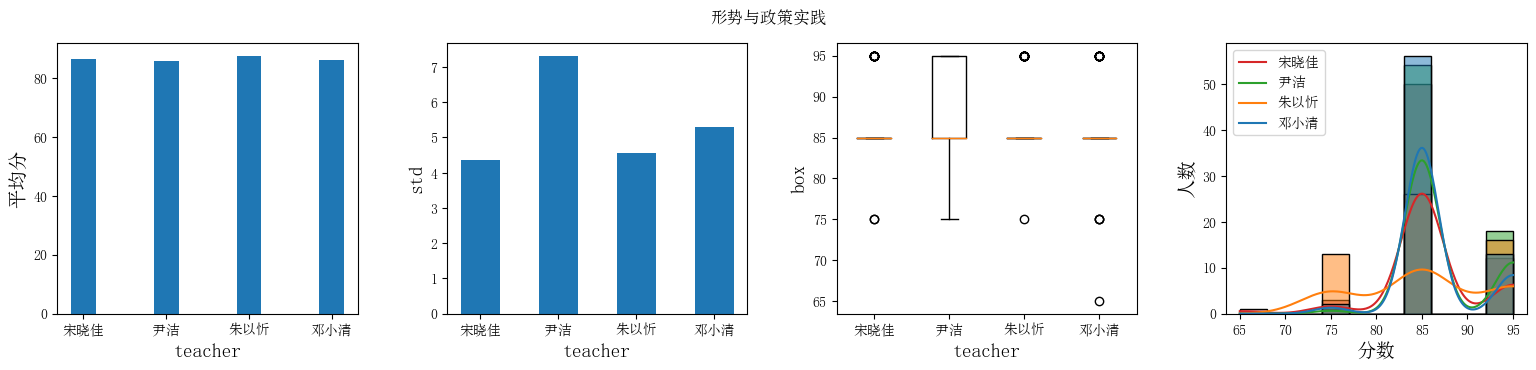

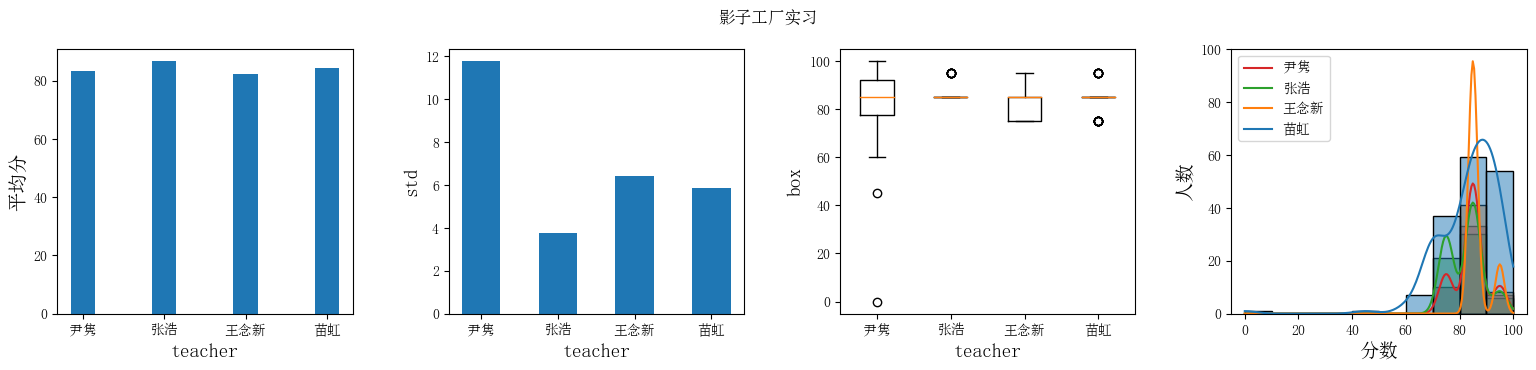

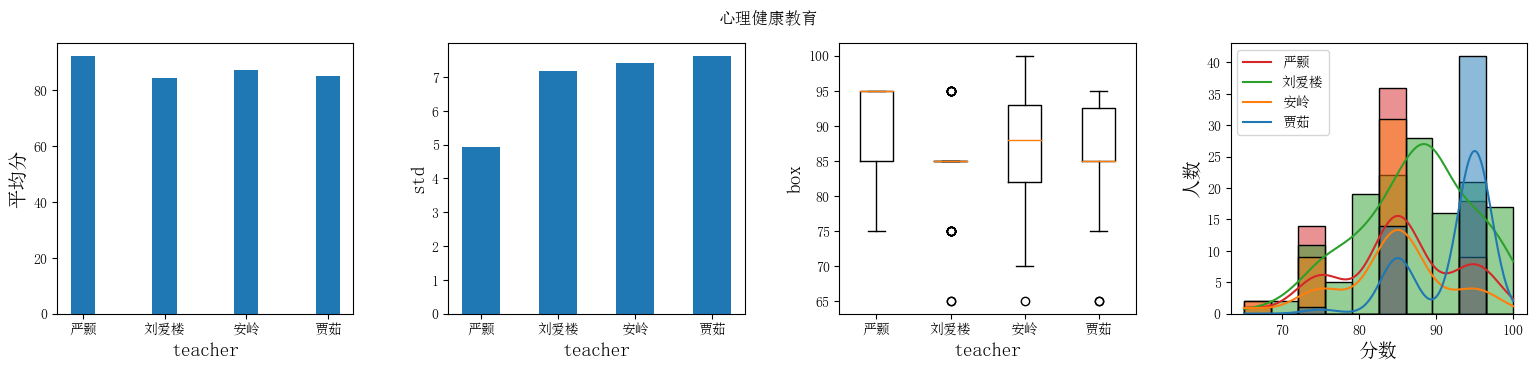

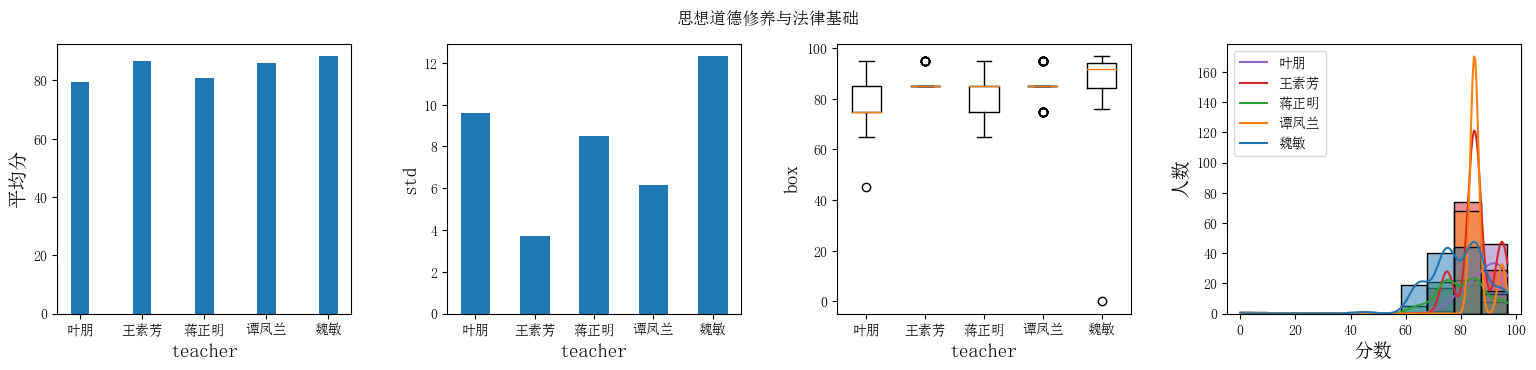

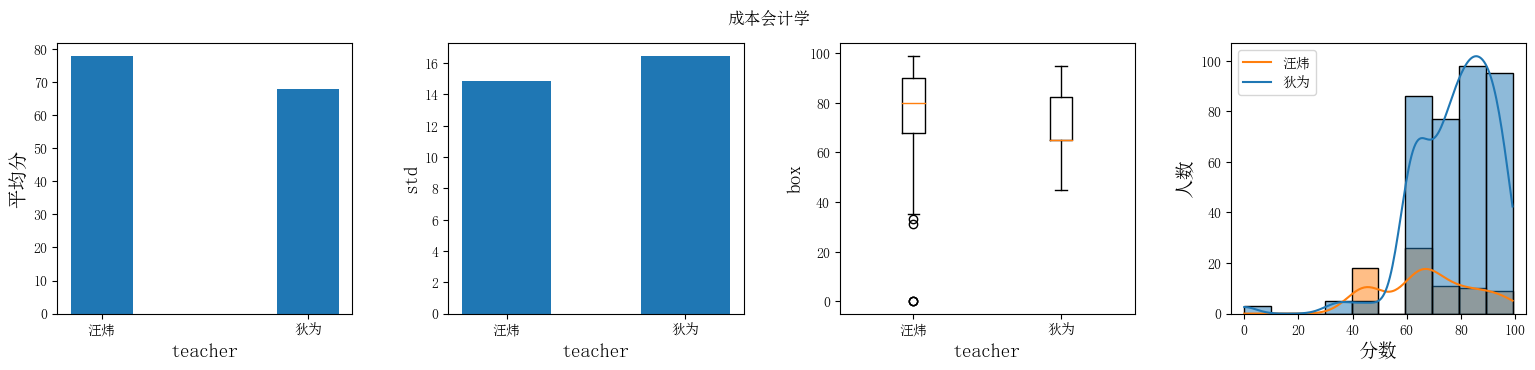

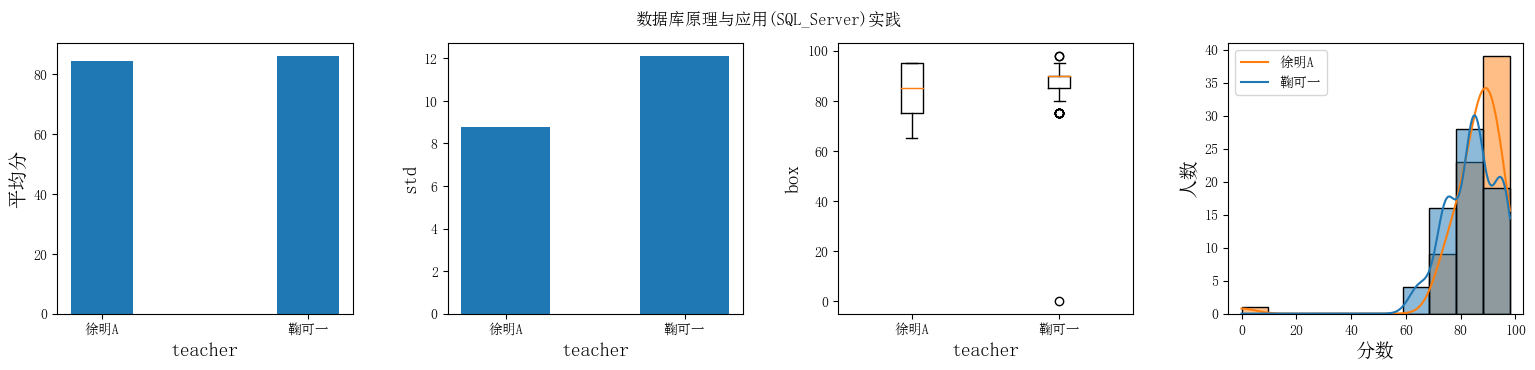

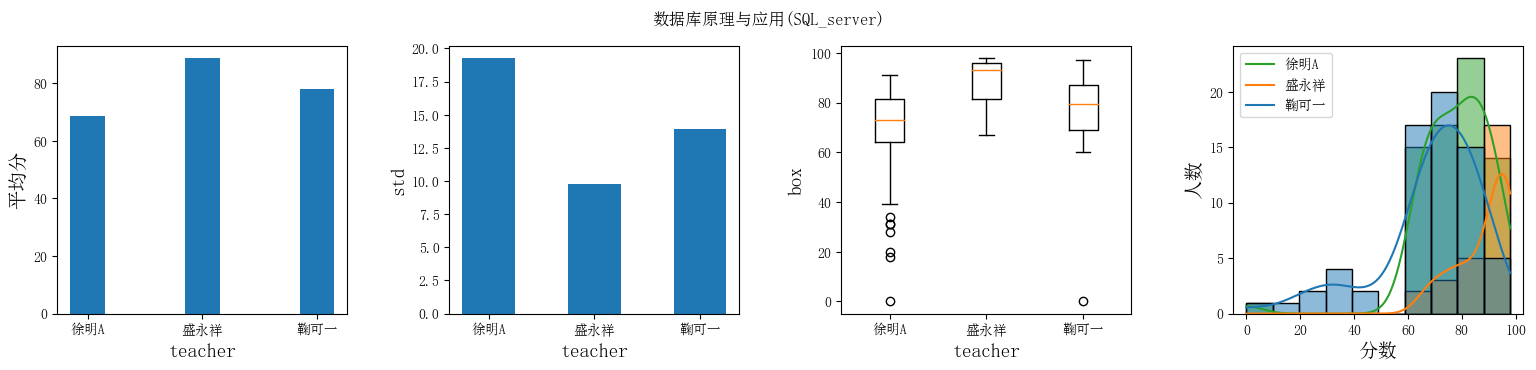

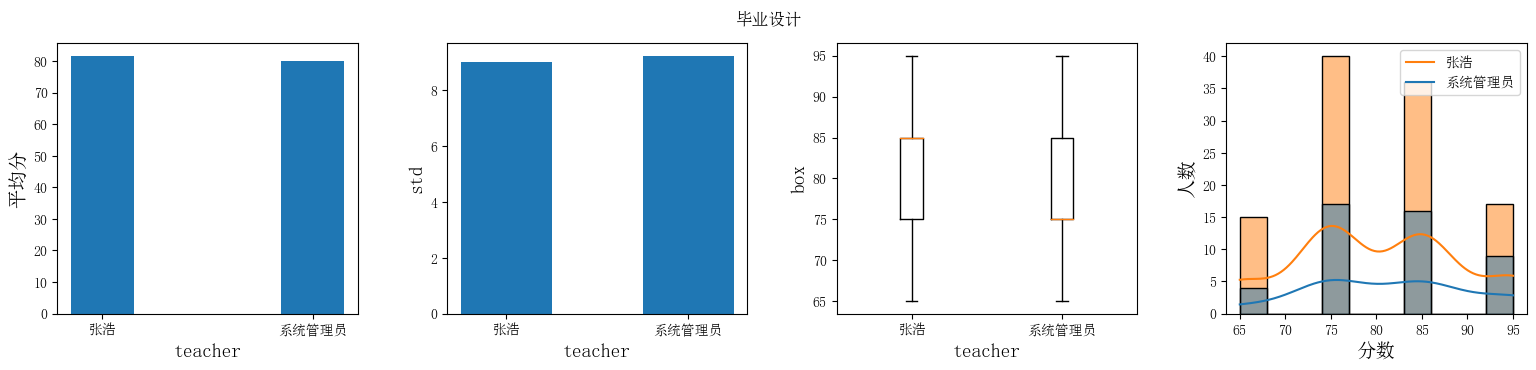

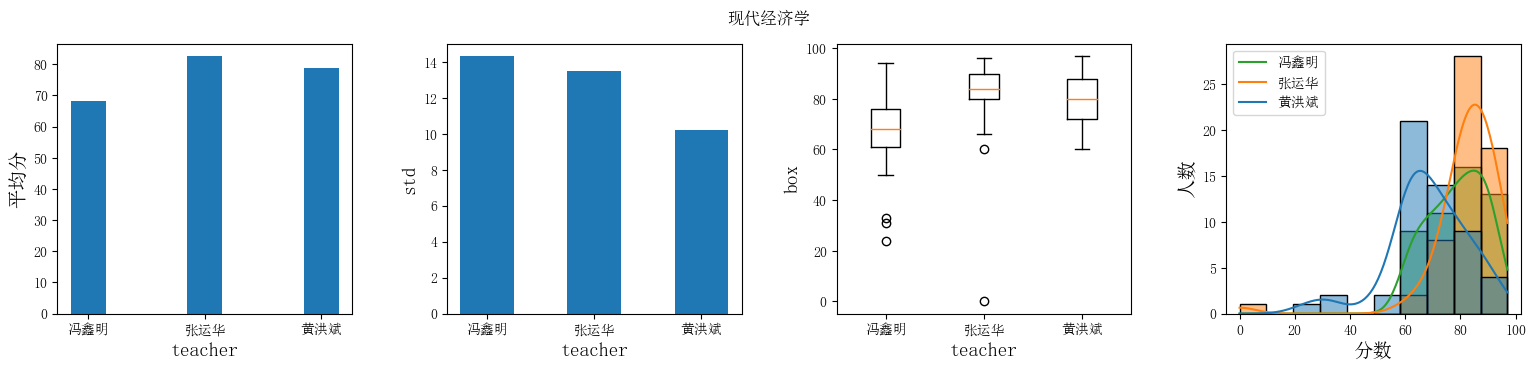

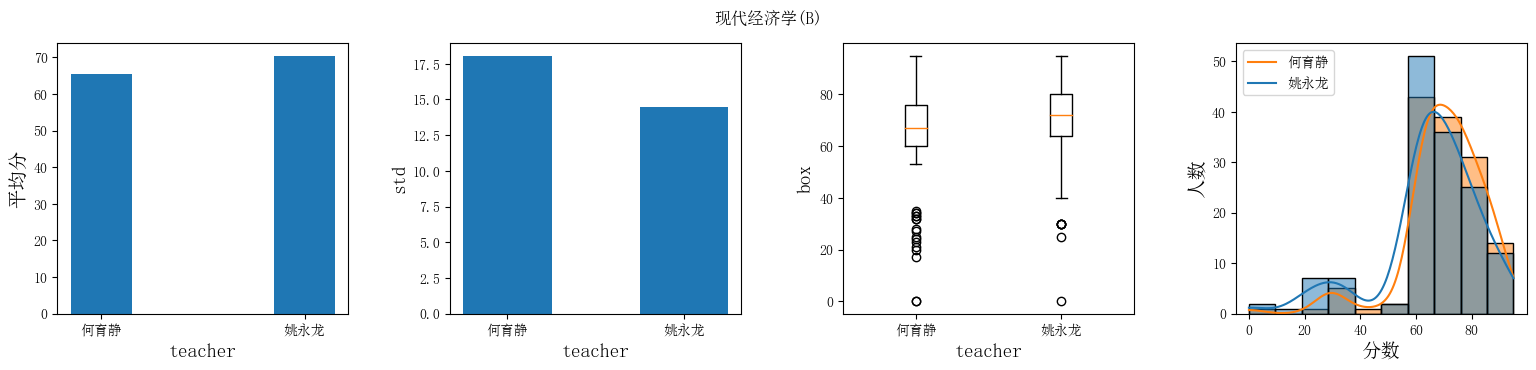

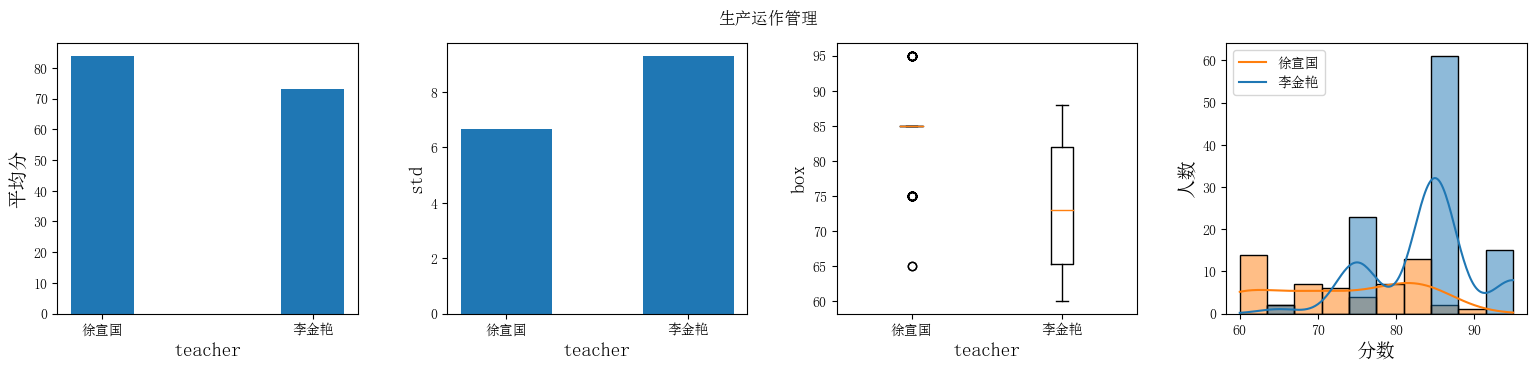

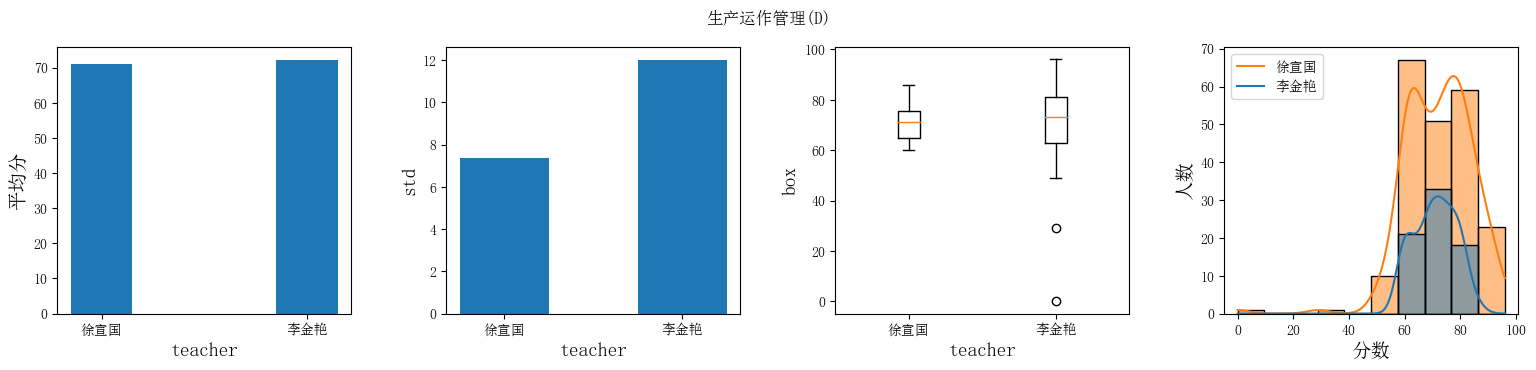

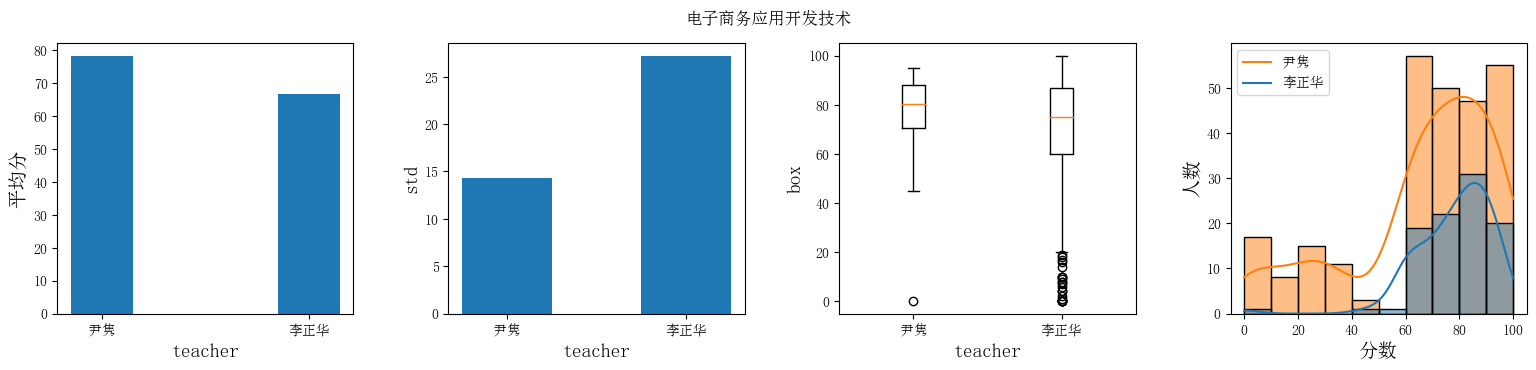

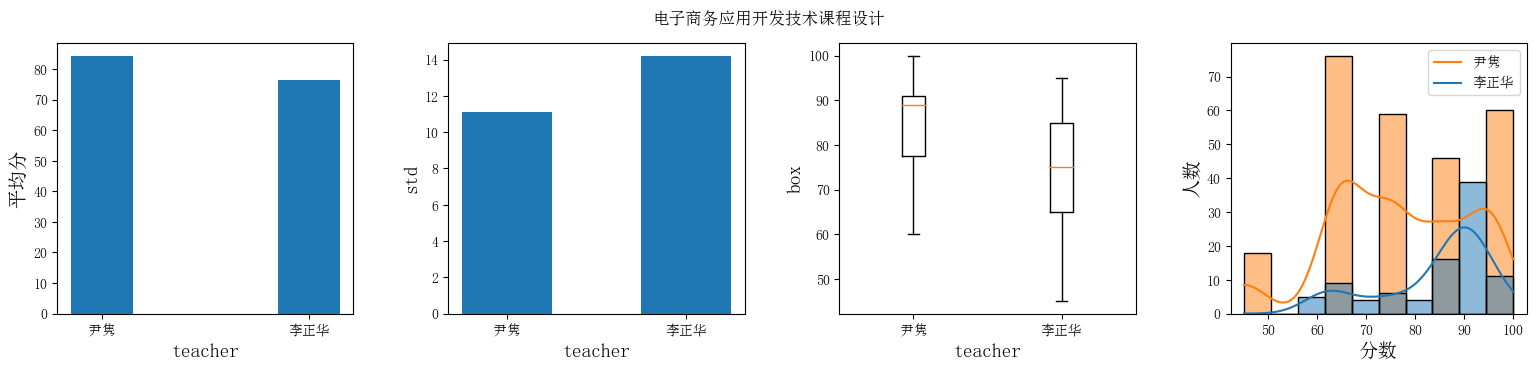

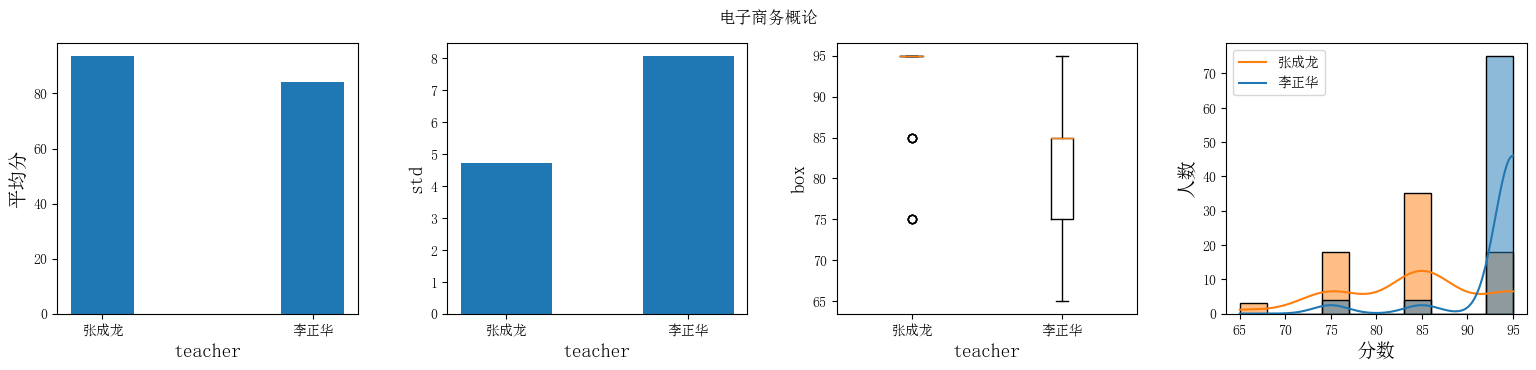

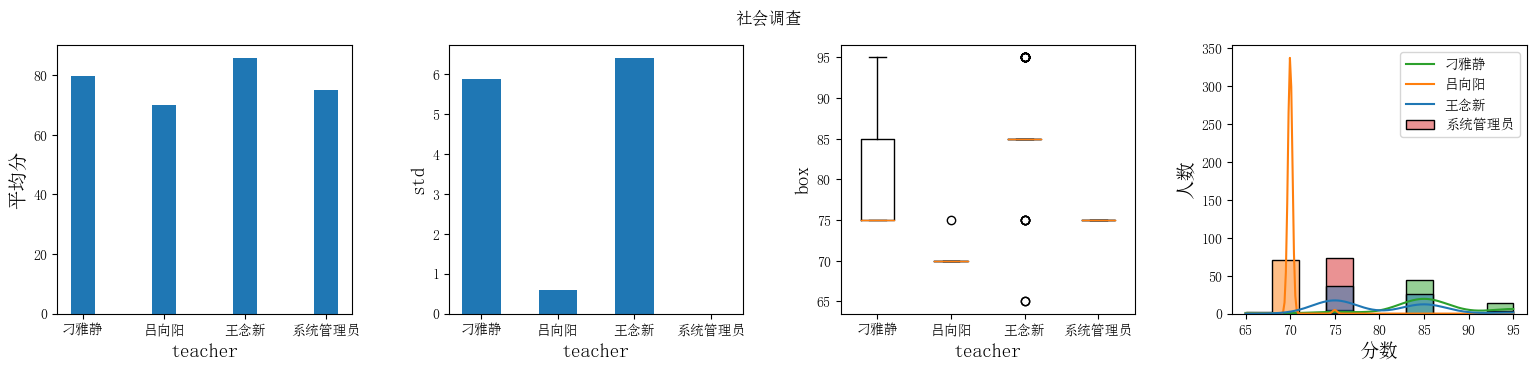

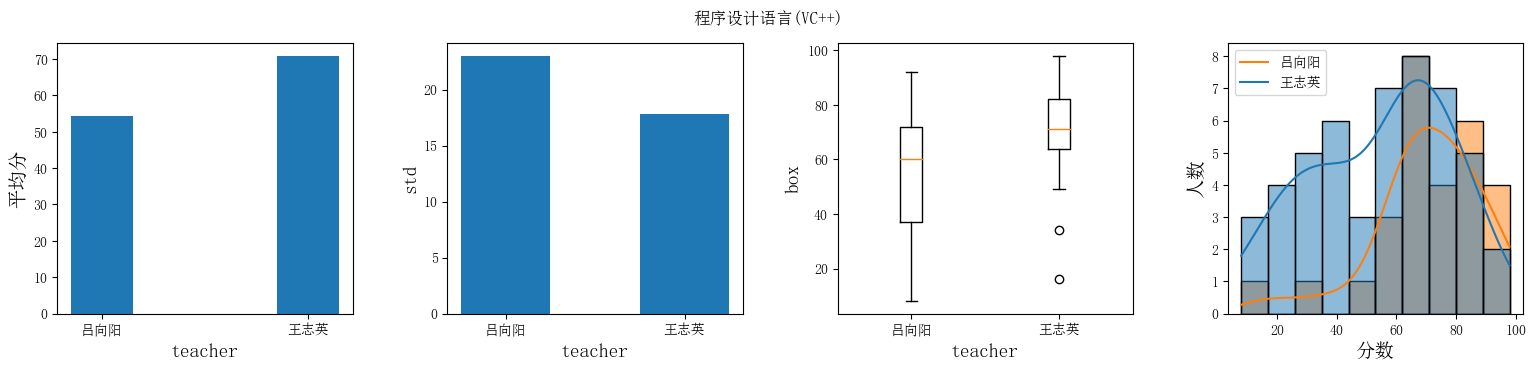

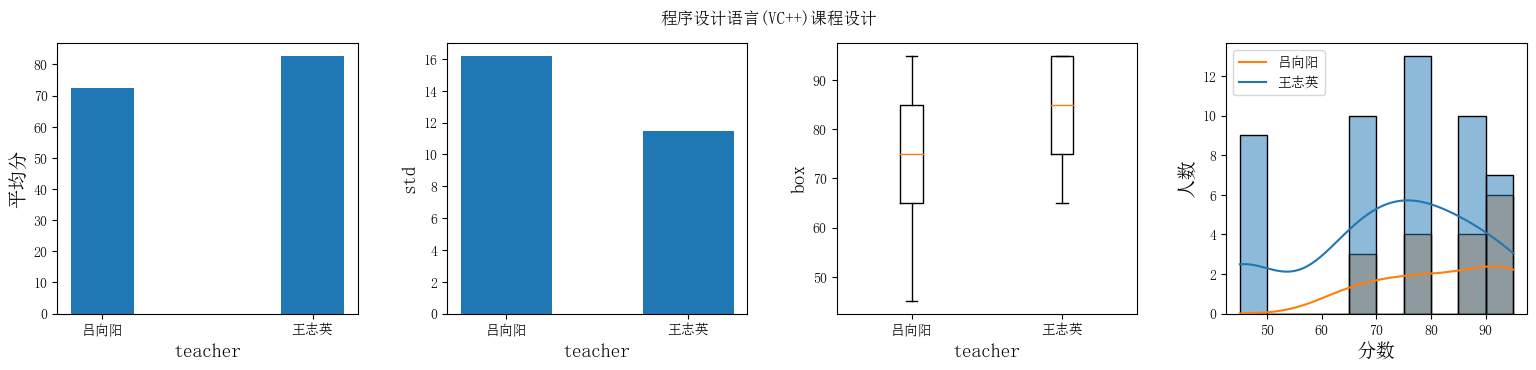

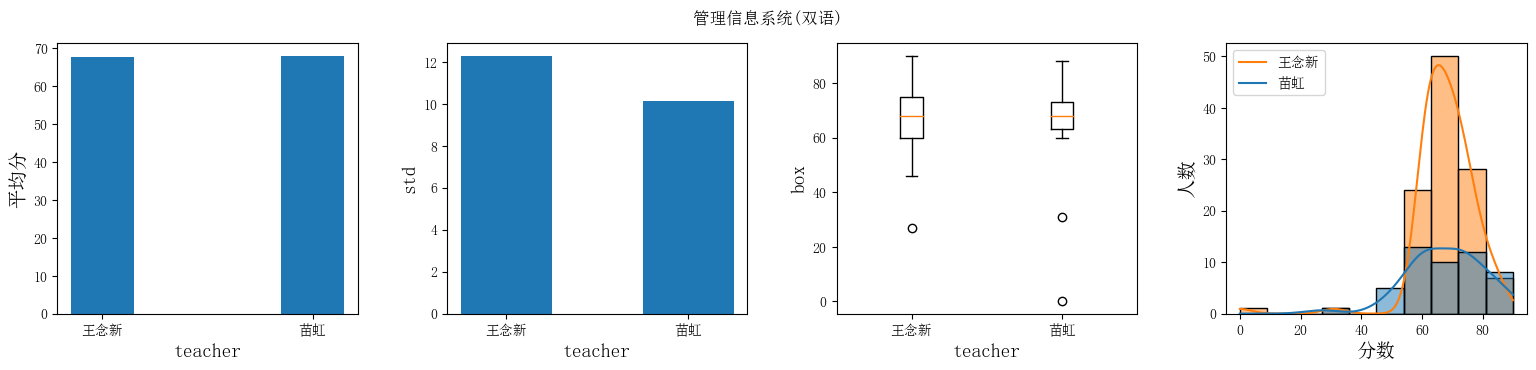

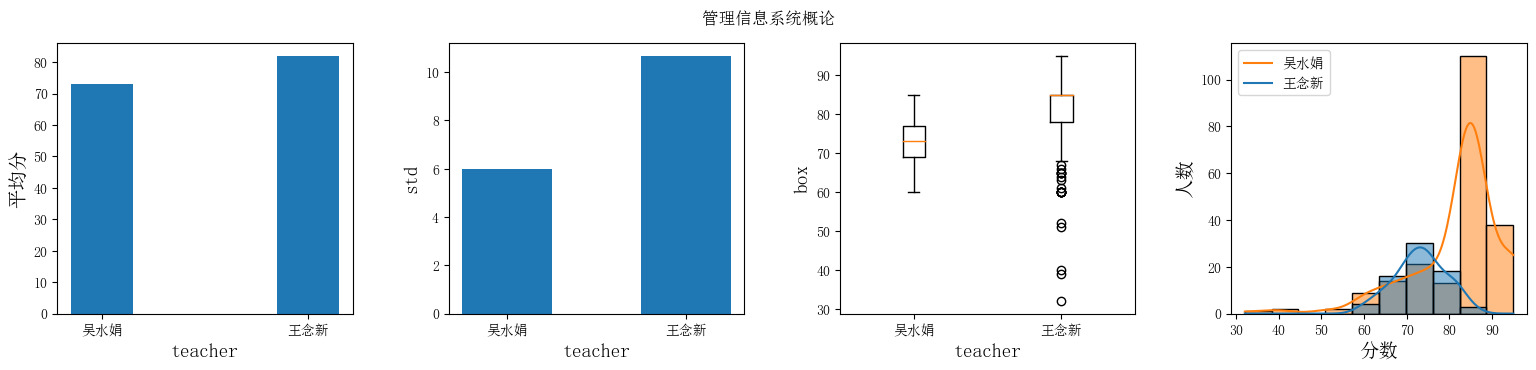

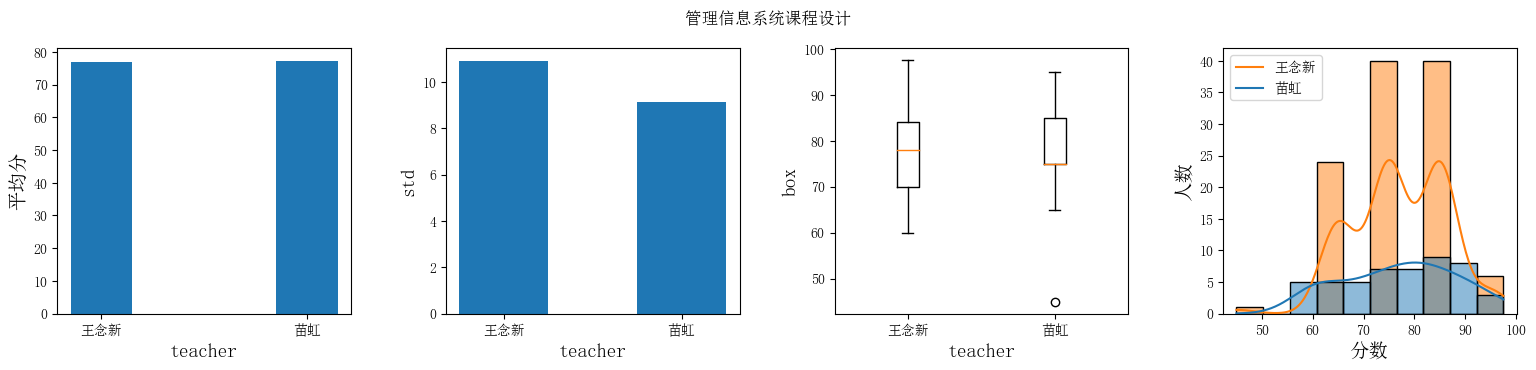

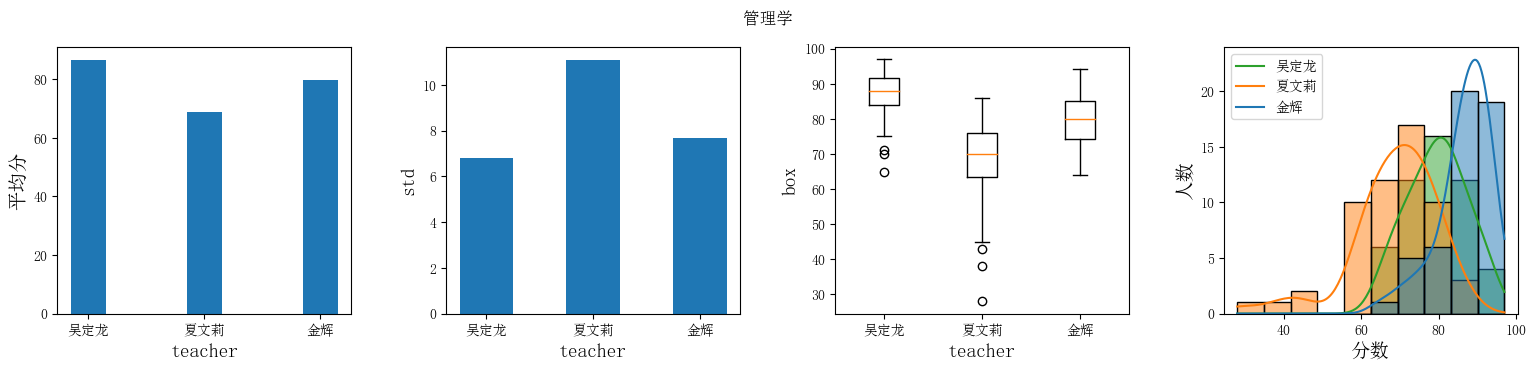

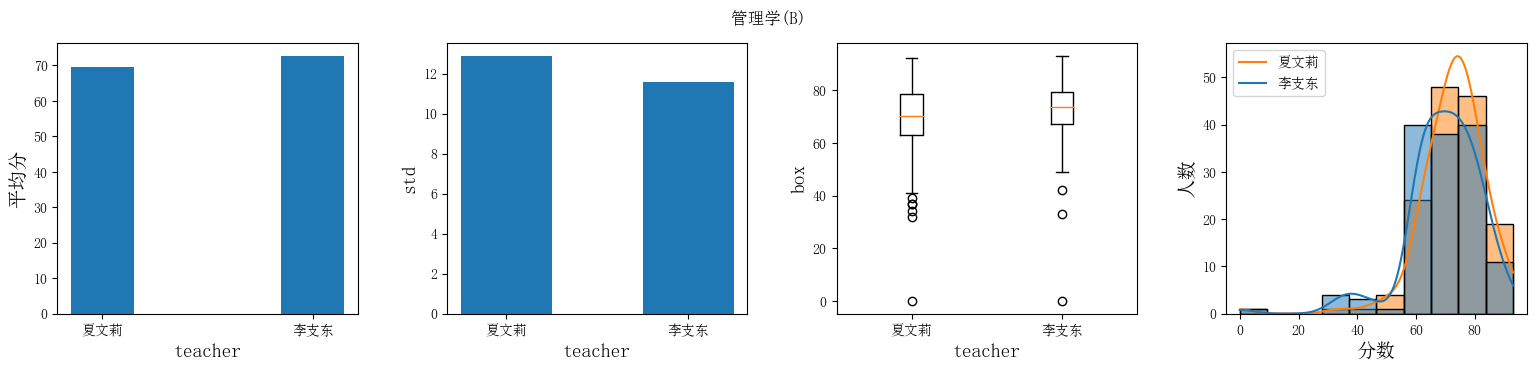

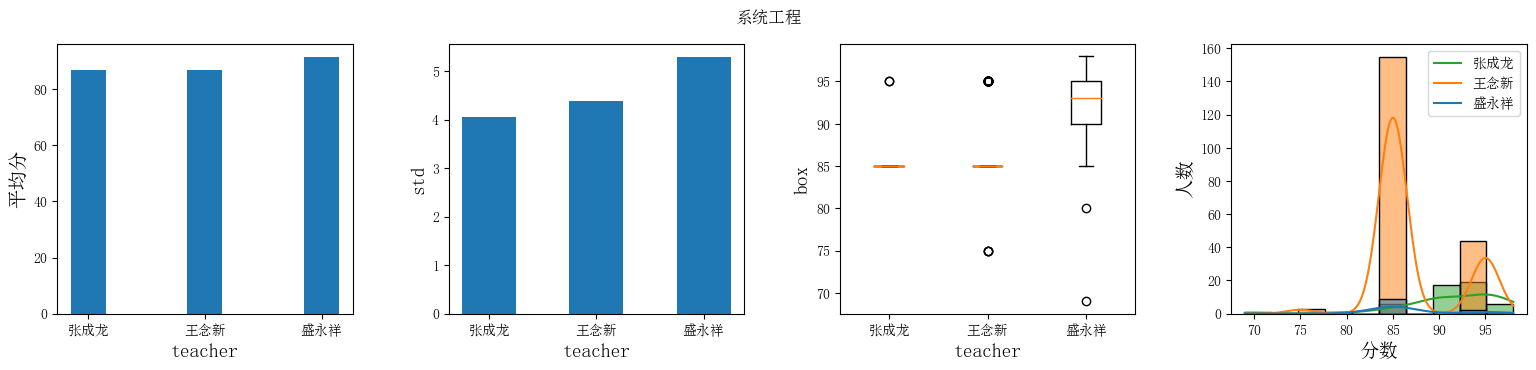

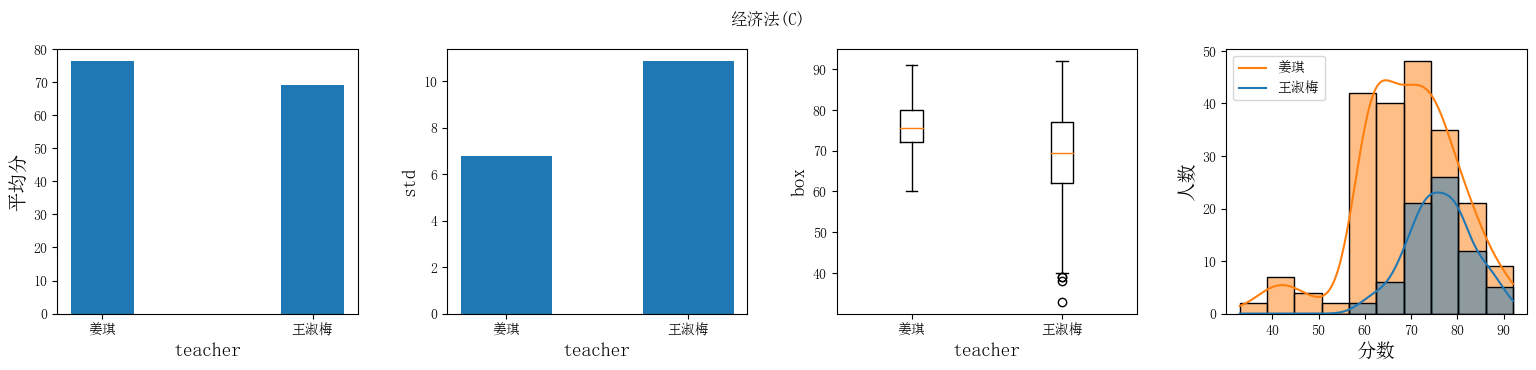

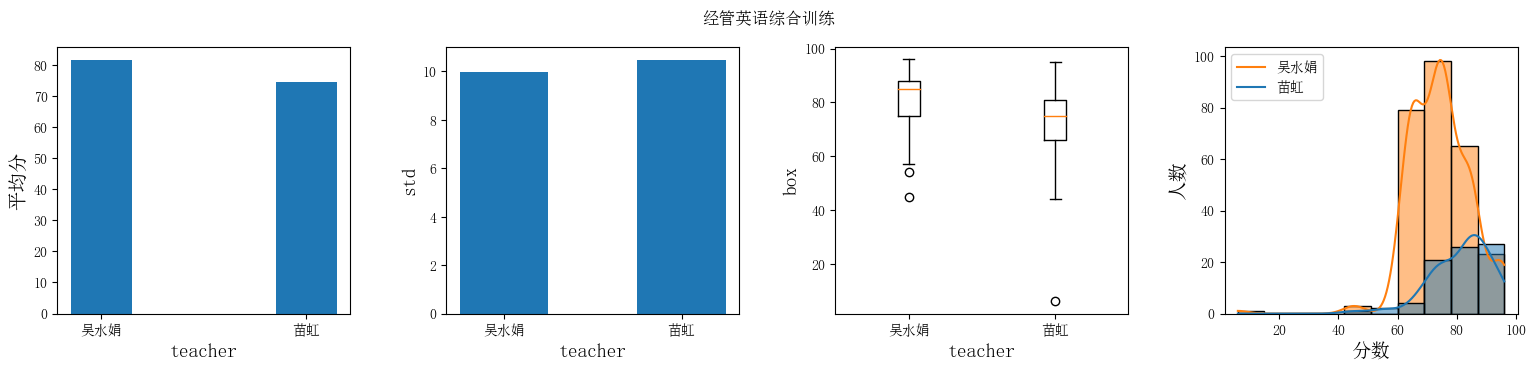

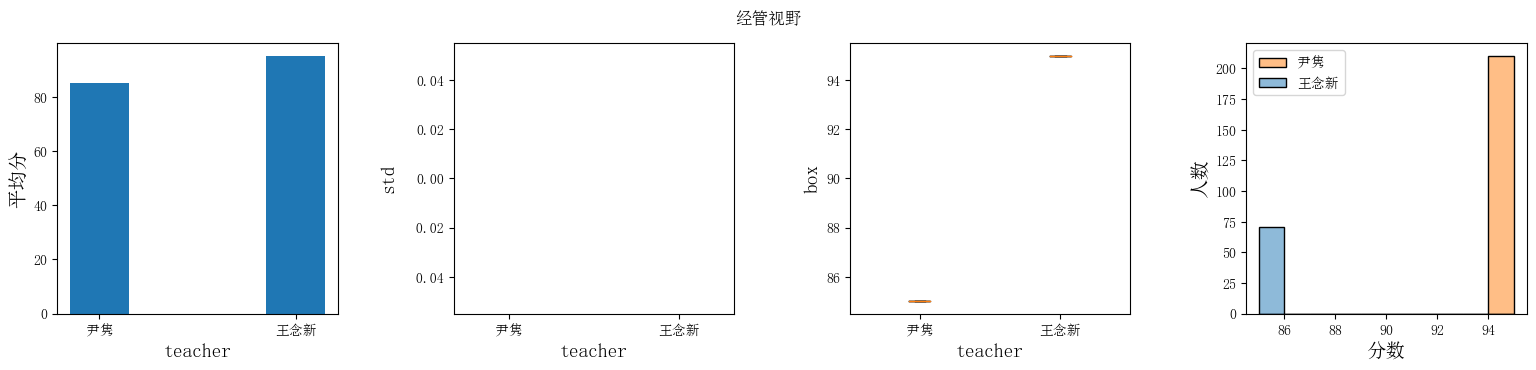

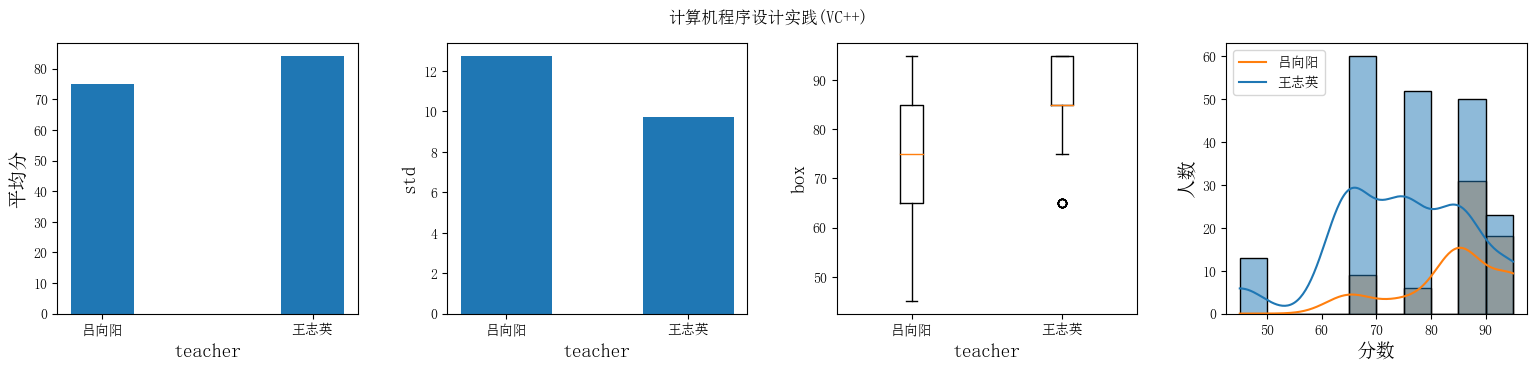

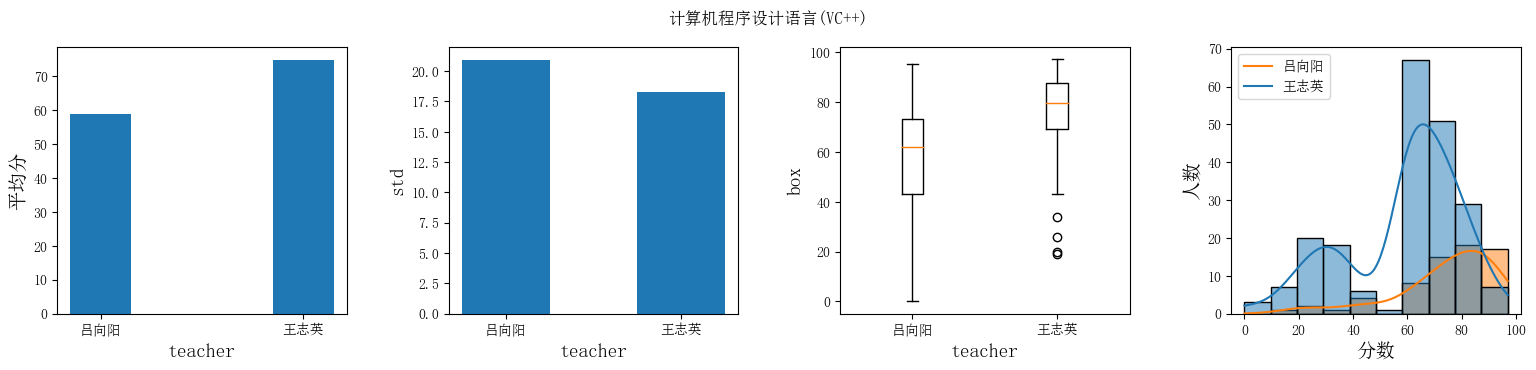

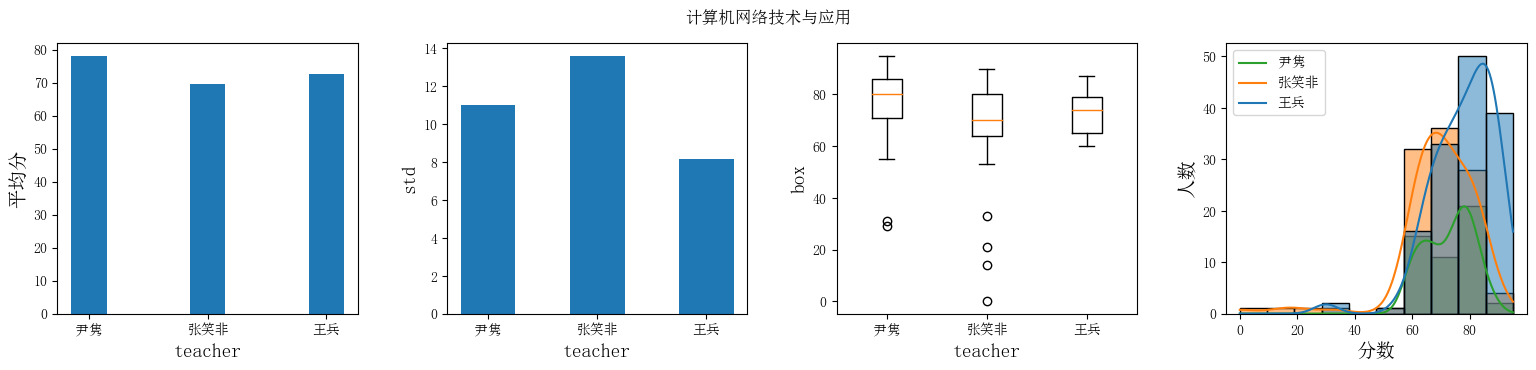

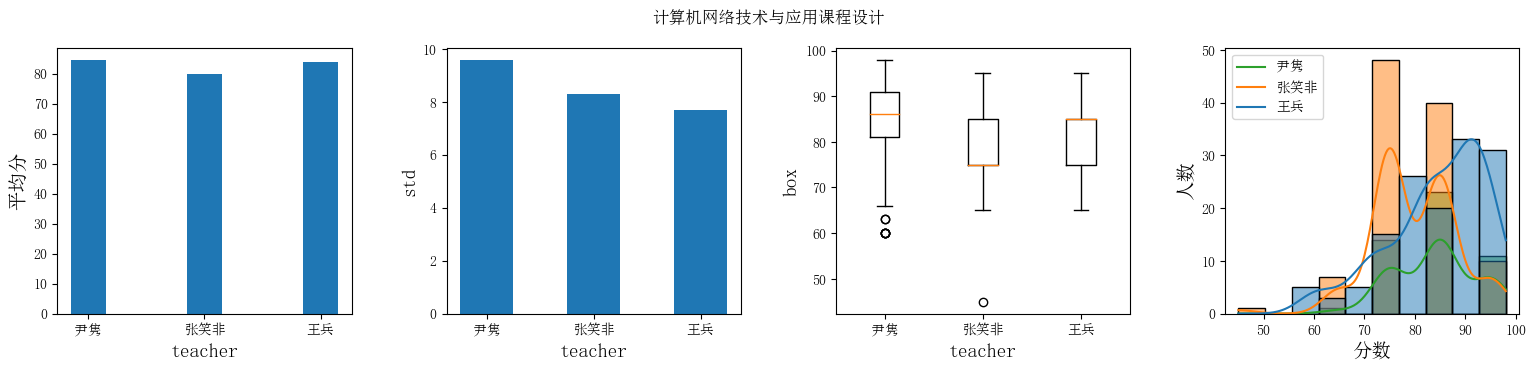

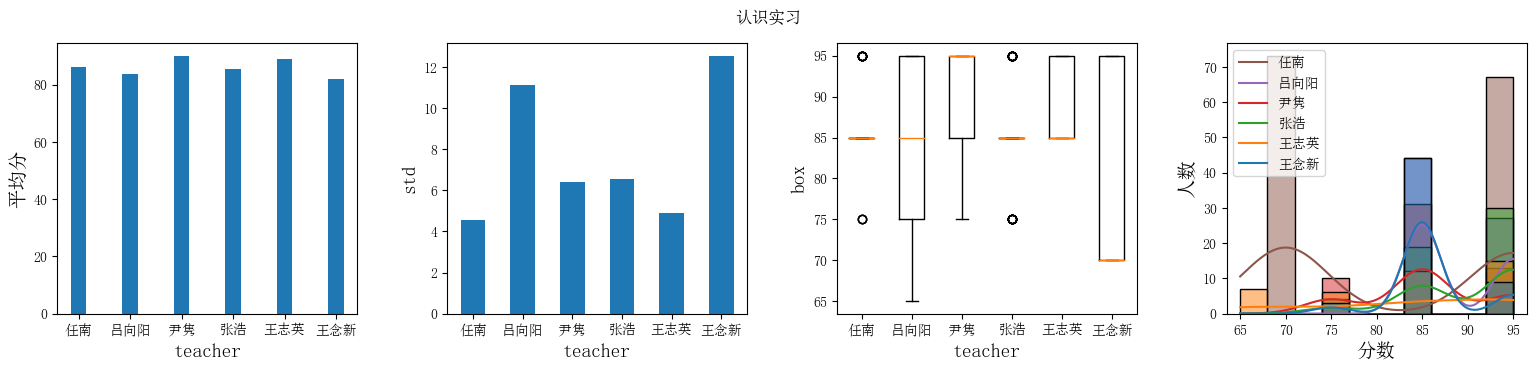

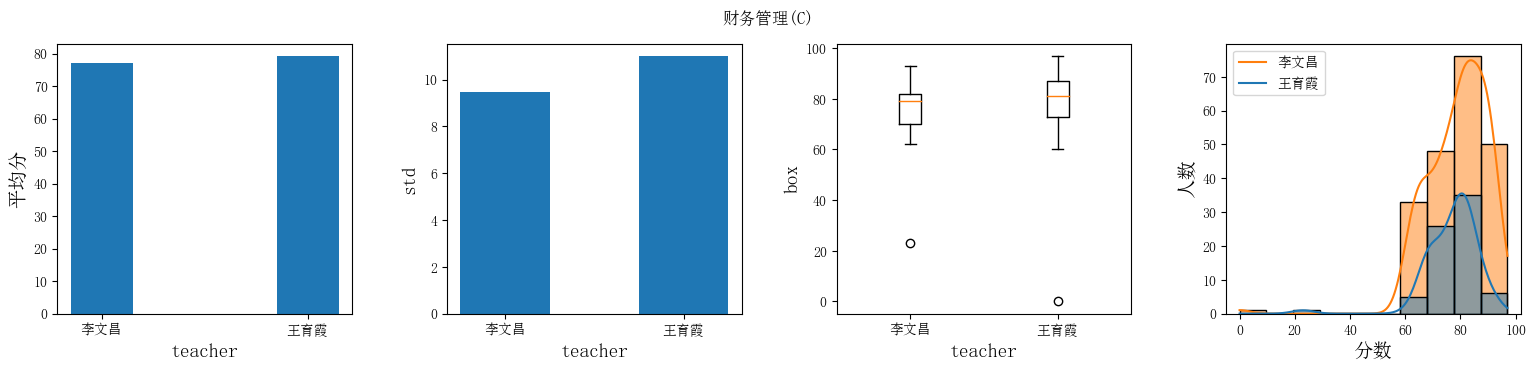

In [44]:
#
for k,v in course.items():
    w = max([16,len(v)/3*8])
    h = min([w/4, 8])
    fig,axes = plt.subplots(1,4,figsize=(w,h),dpi=100)
    teachers = [i[0] for i in v]
    means = [i[1]['mean'] for i in v]
    std = [i[1]['std'] for i in v]
    dot = [i[2] for i in v]
    
    axes[0].bar(teachers,means,width=0.3)
    axes[0].set_xlabel('teacher',fontsize=14)
    axes[0].set_ylabel('平均分',fontsize=14)

    axes[1].bar(teachers,std, width=0.5)
    axes[1].set_xlabel('teacher',fontsize=14)
    axes[1].set_ylabel('std',fontsize=14)
    
    axes[2].boxplot(dot)
    axes[2].set_xlabel('teacher',fontsize=14)
    axes[2].set_ylabel('box',fontsize=14)
    axes[2].set_xticklabels(teachers)
    
    sns.histplot(dot,bins=10,kde=True,ax=axes[3])
    axes[3].legend(teachers)
    axes[3].set_xlabel('分数',fontsize=14)
    axes[3].set_ylabel('人数',fontsize=14)
    
    fig.suptitle(k)
    plt.tight_layout(pad =3)
    plt.show()
#     print(k,v)
#     break

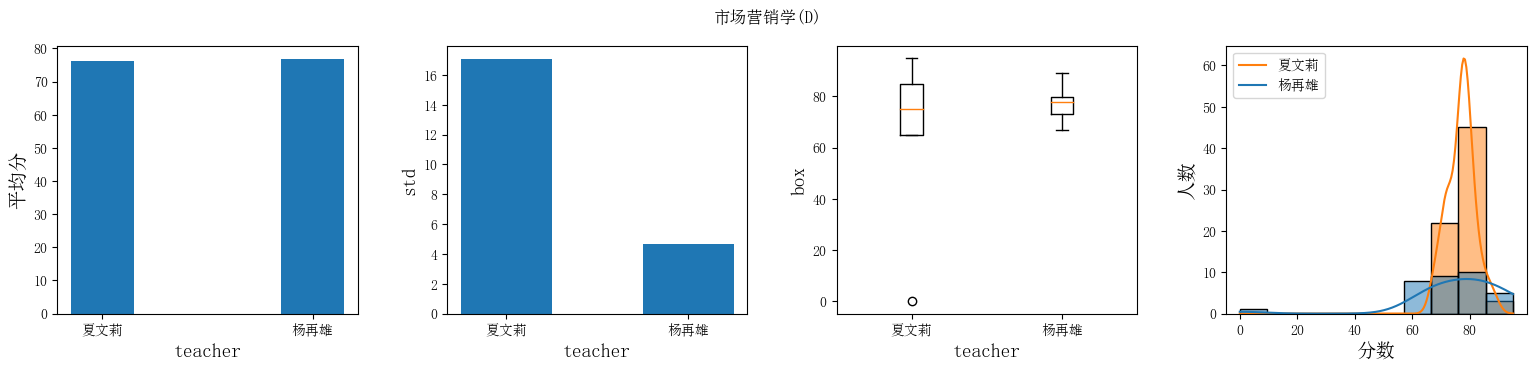

In [45]:
#封装
def plot(k):
    '''
    k: course name
    '''
    v = course[k]
    w = max([16,len(v)/3*8])
    h = min([w/4, 8])
    fig,axes = plt.subplots(1,4,figsize=(w,h),dpi=100)
    teachers = [i[0] for i in v]
    means = [i[1]['mean'] for i in v]
    std = [i[1]['std'] for i in v]
    dot = [i[2] for i in v]

    axes[0].bar(teachers,means,width=0.3)
    axes[0].set_xlabel('teacher',fontsize=14)
    axes[0].set_ylabel('平均分',fontsize=14)

    axes[1].bar(teachers,std, width=0.5)
    axes[1].set_xlabel('teacher',fontsize=14)
    axes[1].set_ylabel('std',fontsize=14)
    
    axes[2].boxplot(dot)
    axes[2].set_xlabel('teacher',fontsize=14)
    axes[2].set_ylabel('box',fontsize=14)
    axes[2].set_xticklabels(teachers)
    
    sns.histplot(dot,bins=10,kde=True,ax=axes[3])
    axes[3].legend(teachers)
    axes[3].set_xlabel('分数',fontsize=14)
    axes[3].set_ylabel('人数',fontsize=14)
    
    fig.suptitle(k)
    plt.tight_layout(pad =3)
    plt.show()
plot('市场营销学(D)')

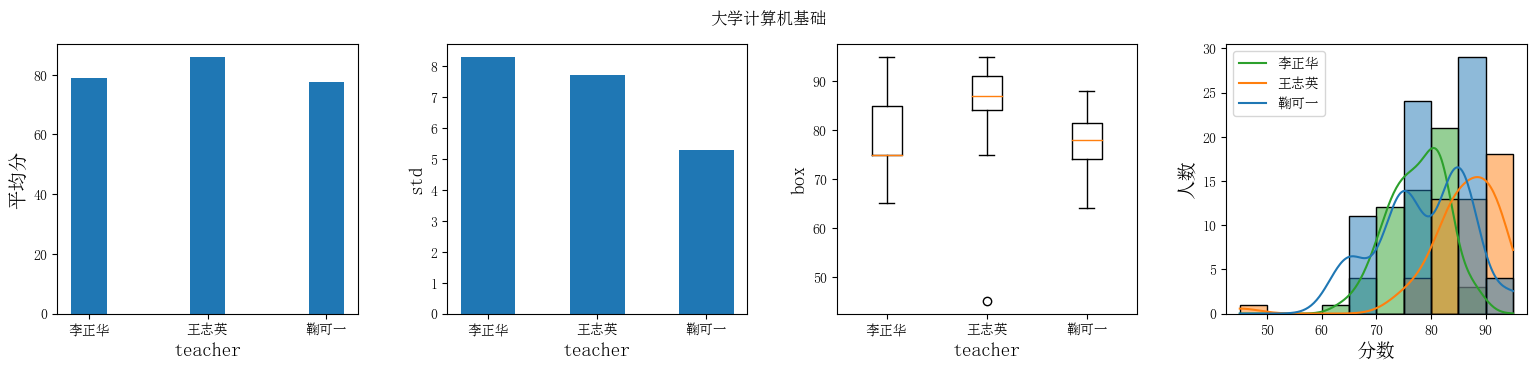

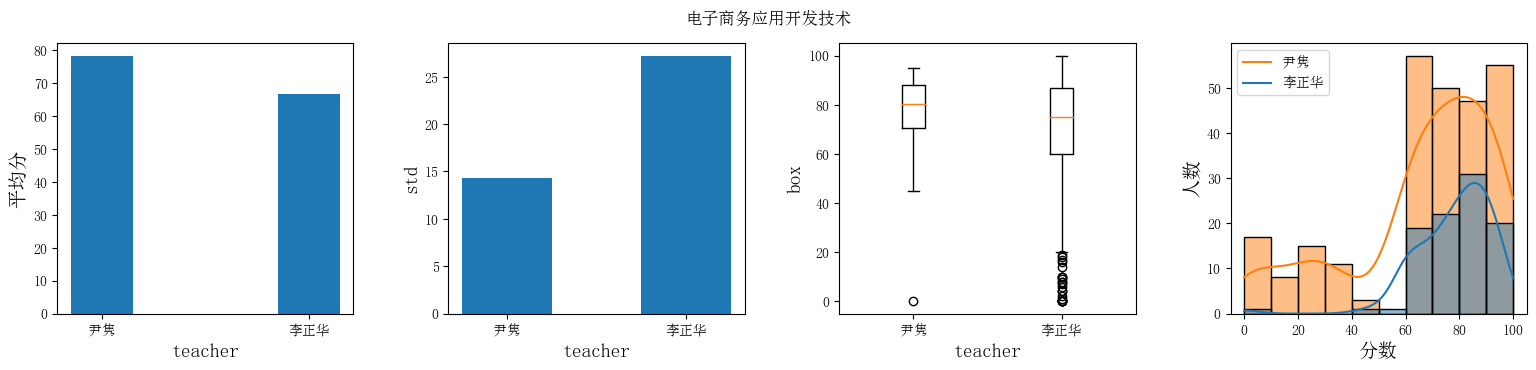

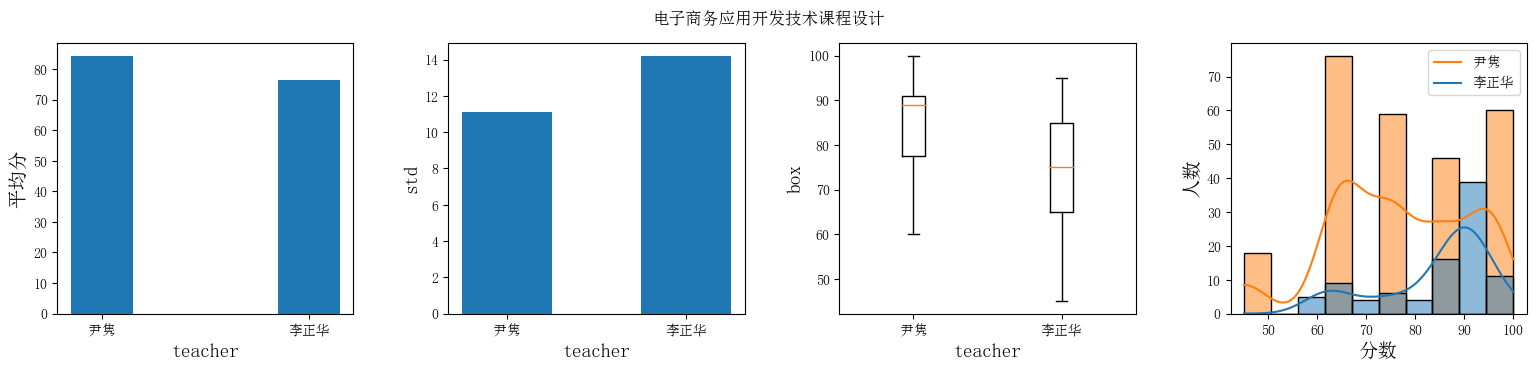

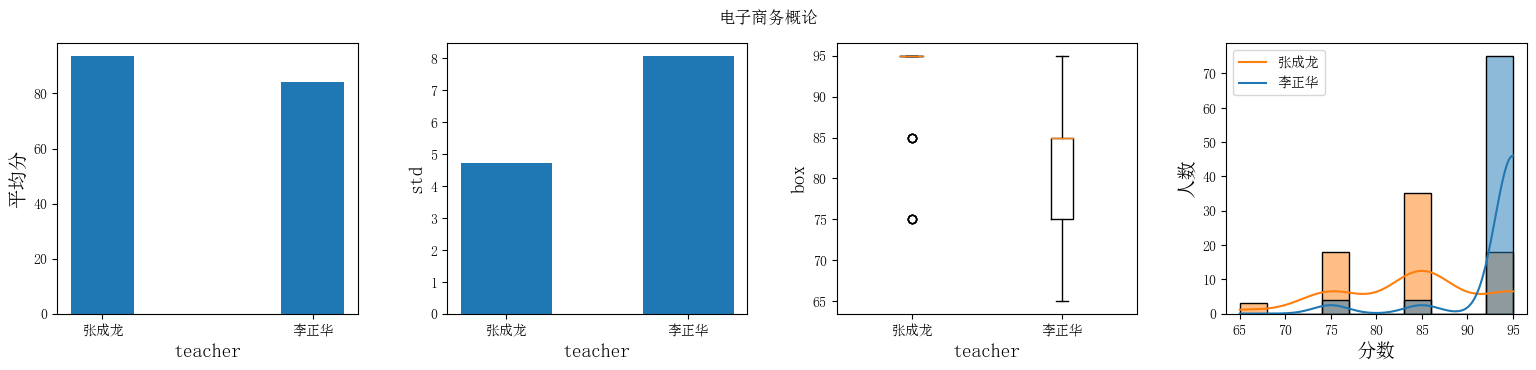

**********


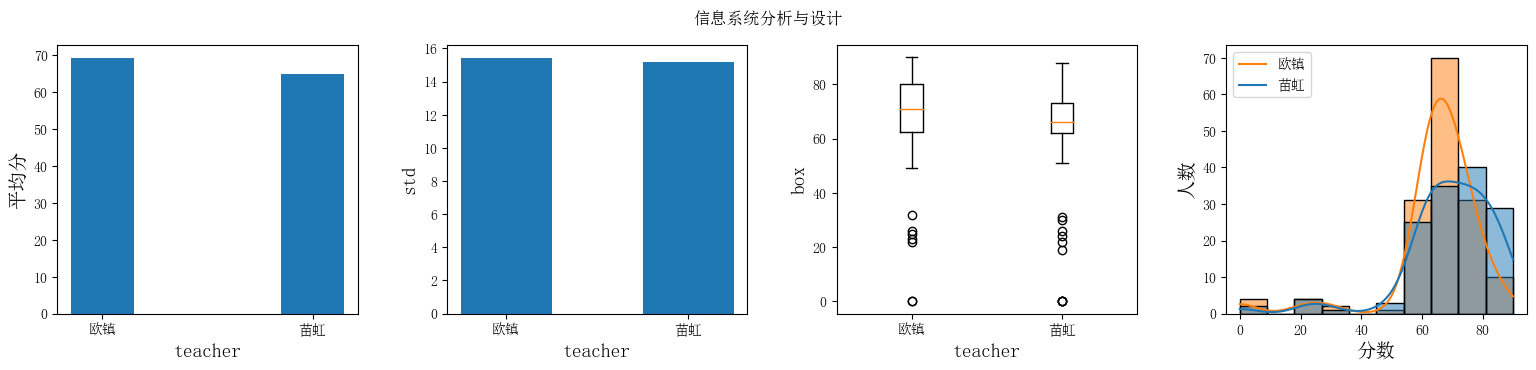

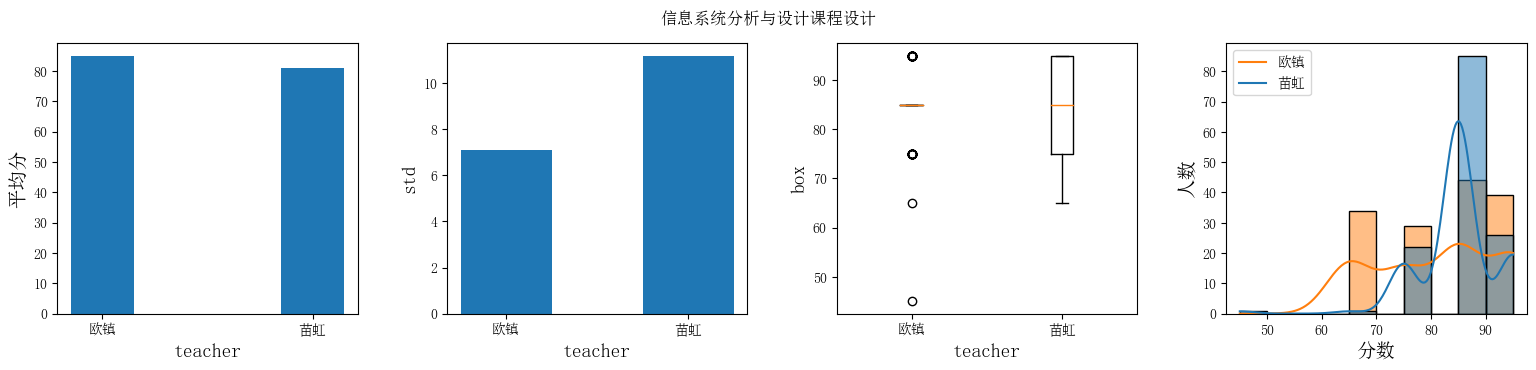

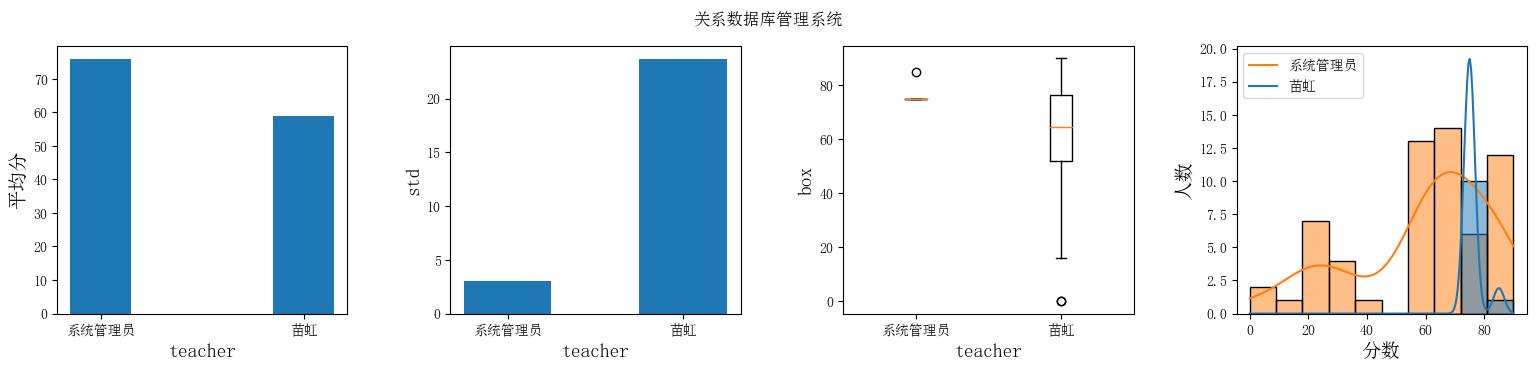

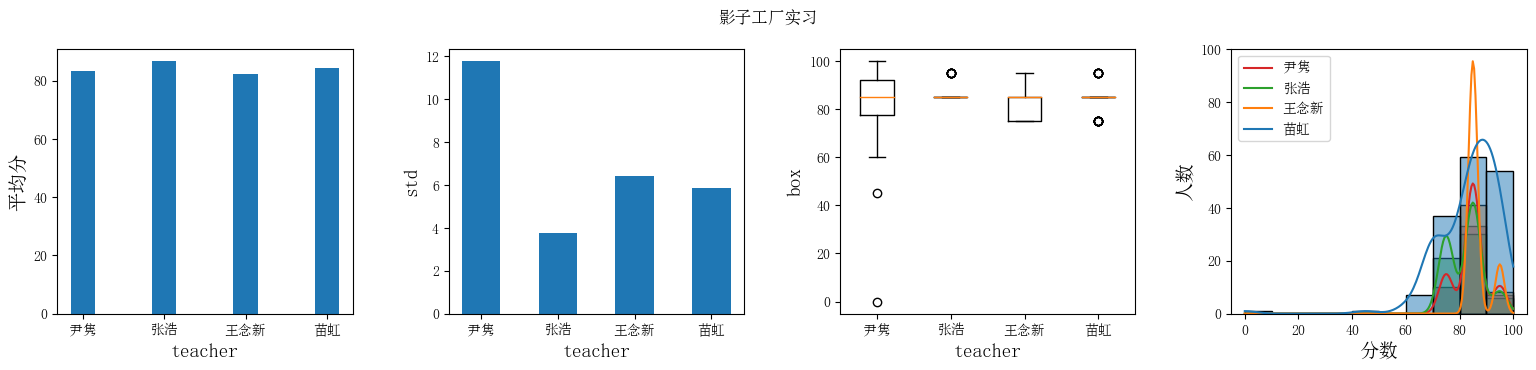

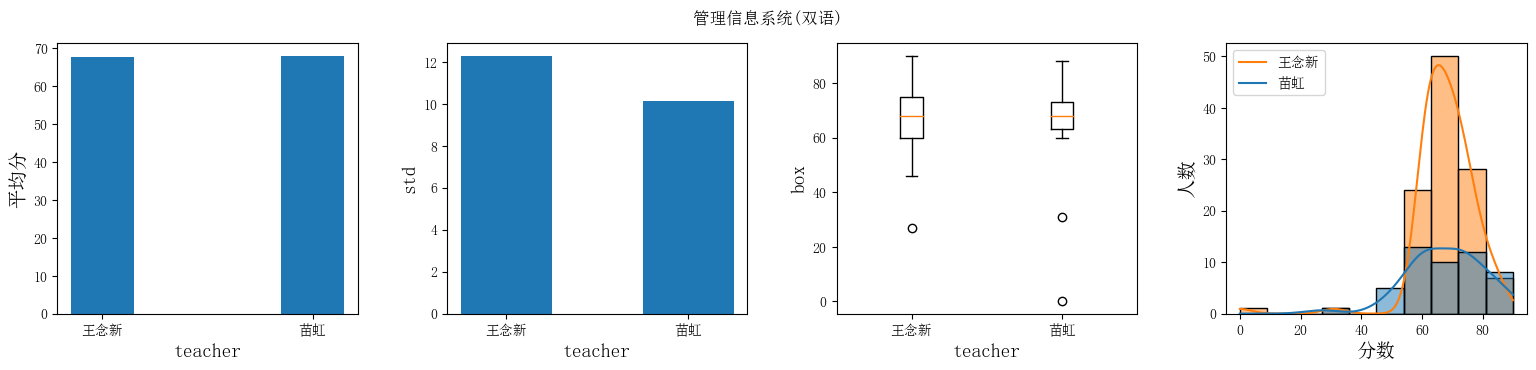

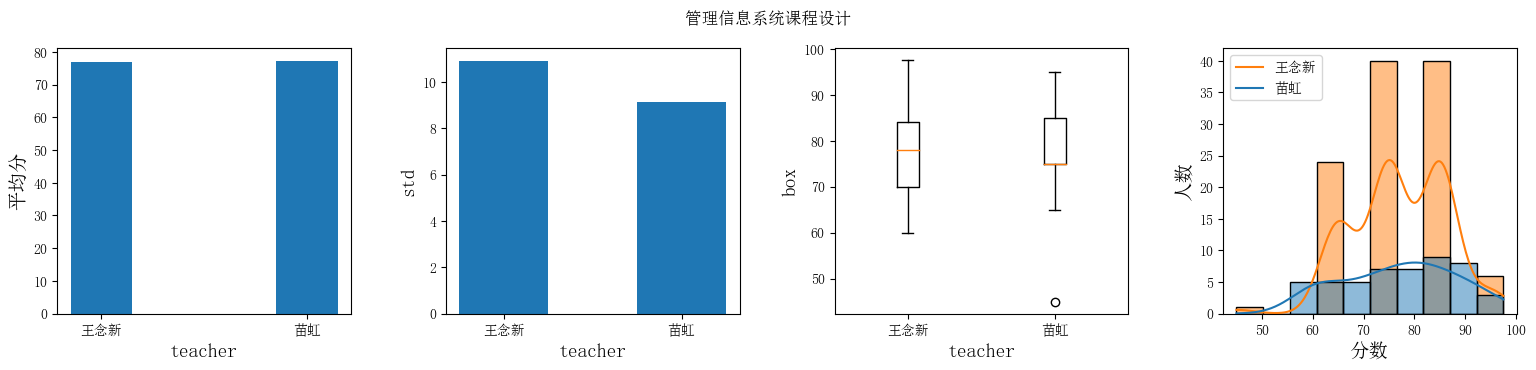

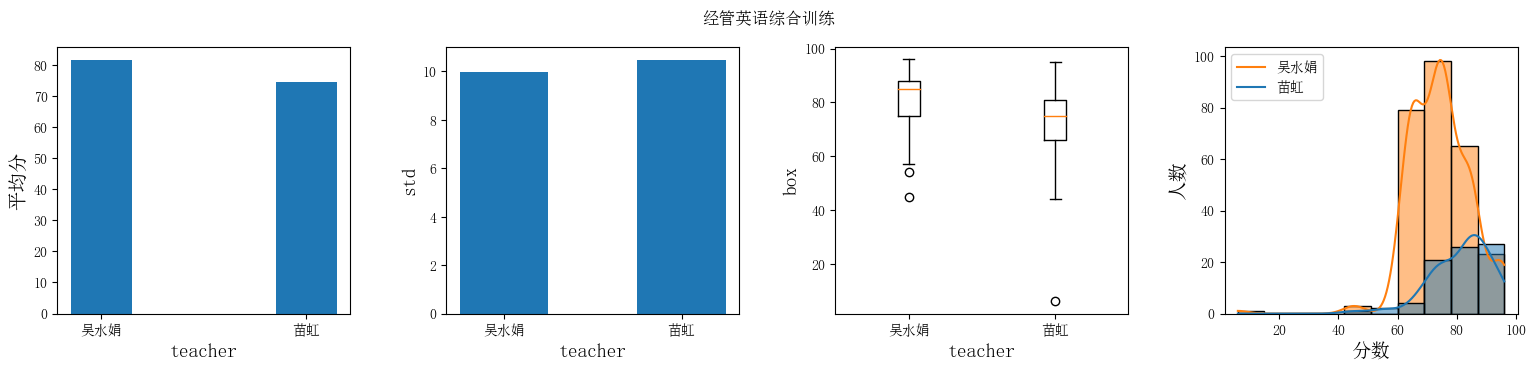

In [46]:
#寻找一个老师相关的全部课程并输出
def find_teacher(teacher):
    for k,v in course.items():
        teachers = [i[0] for i in v]
        if teacher not in teachers:
            continue
        plot(k)
        
teacher = '李正华'
find_teacher(teacher)
print('**********')
teacher = '苗虹'
find_teacher(teacher)

#### 结论
- 一般来说，打分的平均分越低，往往分数的标准差越高，这是因为，平均分较低的分数打的范围比较广泛，导致方差较高，均值较低，也更<br>类似于正态分布</br>。平均分较高的，分数比较集中，标准差也比较低。<font color='#aaa'>当然这只是猜测，还需要计算，平均分的高低与标准差之间的相关性,但这并不简单的同时计算所有课程的，因为不同课程之间是有差异的</font>
- 不同的课程，相同的教师打分也是有差异的，可能很集中，也能分布比较广泛。